In [22]:
# FEED ME SEVERAL GENESIS OUTPUT FILES

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/sdf/home/j/jytang/beamphysics/genesis/CBXFEL')
sys.path.insert(0, '/sdf/home/j/jytang/beamphysics/genesis/CBXFEL/genesis_interface')
sys.path.insert(0, '/sdf/home/j/jytang/beamphysics/genesis/CBXFEL/cavity_codes')

import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib
import numpy as np
import scipy.integrate as sint
import scipy.optimize as sopt
from scipy.interpolate import interp1d
import scipy.special as sspec
import pandas as pd
import itertools
from multiprocessing import Pool
from shutil import copyfile
from IPython import display
from numba import jit
import os, sys
from stats import *
from matplotlib.ticker import FormatStrFormatter
import genesis, parsers, lattice, analysis, lattice_operations, bsub, writers, wakefields#, interactive
import pickle
font = {#'family' : 'helvetica',
        #'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

colorlist=['#f3ffa0', '#6BCAE2', '#72bda3', '#ed6a5a', '#533a71']
colorlist2=['#E2836A','#6a7ee2','#74e26a']

from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
basedir = '../data_3GeV/'
# basedir = './run3_moreheater/'
files = np.array(os.listdir(basedir))
files = files[np.array(['tap0.046_' in file for file in files])]
files = files[np.array(['K0.477' in file for file in files])]
files = files[np.array(['.ou' in file for file in files])]
files = files[np.array(['.log' not in file for file in files])]
files = files[np.array(['dfl' not in file for file in files])]
#files = files[np.array(['K0.4789_' in file for file in files])]
#files = files[np.array(['nf2'  in file for file in files])]
files = files[np.array(['n0.ou'  in file for file in files])]
#files = files[np.array(['n100' in file for file in files])]
files = files[np.array(['.swp'  not in file for file in files])]
files = np.array([basedir+file for file in files])
files = np.sort(files)
files

array(['../data_3GeV/tap0.046_K0.477_n0.out'], dtype='<U35')

In [32]:
filenames = files
showPlotQ = True
# if(len(sys.argv) > 1):
#     if sys.argv[1] == '-p' or sys.argv[1] == '-sp' or sys.argv[1] == '--plot' or sys.argv[1] == '--showplot':
#         showPlotQ = True
#         filenames = sys.argv[2:]
#         #filename = sys.argv[2]
#     else:
#         filenames = sys.argv[1:]
#         #filename = sys.argv[1]
# else:
#     print('Please specify a filename.')
#     break_code_error_check_me

records = []
for filename in filenames:
    record = {}

    basedir = '/'.join(filename.split('/')[:-1])
    workdir = basedir
    genoutfn = filename.split('/')[-1]
    fnhead = '.'.join(filename.split('/')[-1].split('.')[:-1])
    print('filename = ', filename)
    print('basedir = ', basedir)
    print('workdir = ', workdir)
    print('genoutfn = ', genoutfn)
    print('fnhead = ', fnhead)
    #break_code_xngdhgdjgdfj
    
    record['fnhead'] = fnhead
    record['genoutfn'] = genoutfn
    record['basedir'] = basedir
    record['workdir'] = workdir

    ## paths
    #basedir = '/gpfs/slac/staas/fs1/g/g.beamphysics/jduris'
    ##workdir = basedir+'/lh_shaping/LH_package_LCLSII_sc/elegant/scan_lower_edge_slopedwall/t0_-1_sigt_7_a0_0_a1_1_a2_1.5_a3_1_a4_10_l1p_-19.2_c1p_-148.97_l2p_-22.754_l3p_0.71_bc1_1_bc2_1.0201'#/genesis_charge_43pct_too_high'
    ##workdir += '/genesis_wcoefz_13.1_0.018_2'
    ##workdir += '/genesis_wcoefz_13.1_0.03_2'
    ##workdir += '/genesis_wcoefz_13.1_0.04_2'
    ##workdir += '/genesis_wcoefz_13.1_0.05_2'
    ##workdir += '/genesis_wcoefz_13.1_0.06_2'
    ##workdir += '/genesis_wcoefz_13.1_0.07_2' # best?
    ##workdir += '/genesis_wcoefz_13.1_0.08_2'
    ##workdir += '/genesis_wcoefz_20.25_0.018_2'
    ##workdir += '/genesis_wcoefz_20.25_0.03_2'
    #workdir = '/nfs/slac/g/beamphysics/jduris/lh_shaping/LH_package_LCLSII_sc/elegant/scan_sloped_wall_flatbeam_700A/t0_-1_dt_601793005265.1469_sigt_2_A_0_B_0_l1p_-19.2_c1p_-148.97_l2p_-20.754_l3p_0.71_bc1_1_bc2_1'
    ##fnhead = 'genesis'
    #fnhead = 'gen_tap_0.0001'
    ##fnhead = 'genesismp'
    savefolder = workdir

    # Setup generic genesis class
    params = {'workdir' : workdir,
            'genesis_bin' : 'genesis_BULLET',
            'input_file' : workdir + '/' + fnhead + '.in',
            'use_tempdir' : False}
    g = genesis.Genesis(**params)
    
    record['params'] = params
    record['g'] = g

    # Load Genesis output data
    g.load_output() # parse output
    zlist = np.asarray(g.output['lattice']['z'])
    slicedat = g.output['slice_data']
    #slist = np.array([sd['index'] for sd in slicedat]) * g.input['xlamds'] / 3e8
    slist = np.array([sd['index'] for sd in slicedat]) * g.input['xlamds'] / 3e8 * g.input['zsep']
    #slist = np.array([sd['index'] for sd in slicedat]) * g.input['xlamds'] * g.input['zsep'] * g.input['ishsty'] / 3e8
    slist_fs = slist * 1e15
    outputdat=[];
    for ii in range(len(slicedat)):
        if np.mod(ii,150)==0: print(ii);
        temp = pd.DataFrame.from_dict(slicedat[ii]['data'])
        temp.insert(0, 'slice', slicedat[ii]['index'])
        temp.insert(0, 'current', slicedat[ii]['current'])
        temp.insert(0, 'z', zlist)
        outputdat.append(temp)
    outputdat = pd.concat(outputdat, axis = 0)
    display.clear_output(wait = True)
    print(outputdat.head())
    currlist = outputdat['current'].iloc[::len(zlist)]
    energylist_init = outputdat['energy'].iloc[::len(zlist)]
    energylist_fin = outputdat['energy'].iloc[len(zlist)-1::len(zlist)]
    
    record['zlist'] = zlist
    record['slicedat'] = slicedat
    record['awlist'] = np.asarray(g.output['lattice']['aw'])
    record['qflist'] = np.asarray(g.output['lattice']['qfld'])
    record['slist'] = slist
    record['slist_fs'] = slist_fs
    record['outputdat'] = outputdat
    record['currlist'] = currlist
    record['energylist_init'] = energylist_init
    record['energylist_fin'] = energylist_fin

    # print pulse energy
    zgroups = outputdat.groupby('z')
    slicegroups = outputdat.groupby('slice');
    pulse_energy = zgroups.agg({'power':'sum'})['power'] * g.input['xlamds'] * g.input['zsep'] * g.input['ishsty'] / 3e8
    print('Peak output power: {:2.2f} GW'.format(outputdat['power'].max() * 1e-9))
    print('Pulse energy from sum of output power: {:2.2f} uJ'.format(pulse_energy.values[-1] * 1e6))
    print('Peak current:', outputdat['current'].max()*1e-3, 'kA')
    print('Average current:', outputdat['current'].mean()*1e-3, 'kA')
    
    record['zgroups'] = zgroups
    record['slicegroups'] = slicegroups
    record['pulse_energy'] = pulse_energy
    
    records += [record]

def getmean(key, records=records):
    arr = np.array([rec[key] for rec in records])
    try:
        return np.mean(arr, axis=0)
    except:
        lens = [len(el) for el in arr]
        print("WARNING: unequal lengths for different files ",[len(el) for el in arr])
        arr = [a[:min(lens)] for a in arr]
        return np.mean(arr, axis=0)

def getmeanovers(key, records=records):
    slists = np.array([rec['slist_fs'] for rec in records])
    smin = np.max([min(slist) for slist in slists])
    smax = np.min([max(slist) for slist in slists])
    snum = np.int(np.mean([len(slist) for slist in slists]))
    slist0 = np.linspace(smin, smax, snum)
    
    arr = np.array([np.interp(slist0, rec['slist_fs'], rec[key]) for rec in records])
    try:
        return slist0, np.mean(arr, axis=0)
    except:
        lens = [len(el) for el in arr]
        print("WARNING: unequal lengths for different files ",[len(el) for el in arr])
        arr = [a[:min(lens)] for a in arr]
        return slist0, np.mean(arr, axis=0)

def getmeanpowers(records=records):
    pows = []
    for rec in records:
        ii = 0; iimax = len(rec['zgroups']) - 1.
        for name,group in rec['zgroups']:
            ii = ii + 1;
            if ii != len(zgroups): continue
            pows += [group['power'].values]
    try:
        return np.mean(pows, axis=0)
    except:
        lens = [len(el) for el in pows]
        print("WARNING: unequal lengths for different files ",[len(el) for el in pows])
        pows = [pow[:min(lens)] for pow in pows]
        return np.mean(pows, axis=0)
        
        

     z  current  slice    power  increment     p_mid  phi_mid    r_size  \
0  0.0   93.416      5   0.0000       0.00  0.000000   0.0000  0.000000   
1  0.1   93.416      5   0.0000       0.00  0.000000   0.0000  0.000000   
2  0.2   93.416      5   0.0000       0.00  0.000000   0.0000  0.000000   
3  0.3   93.416      5   1.3556       0.00  0.074315  -3.0642  0.000028   
4  0.4   93.416      5  16.0940     123.71  0.860750  -3.0600  0.000028   

   energy  bunching  ...           <y>  e-spread     far_field    4th_bunchin  \
0 -4.8458  0.007444  ... -4.044300e-23    1.9569  0.000000e+00  3.870500e-314   
1 -4.8458  0.007371  ... -3.213300e-12    1.9569  0.000000e+00  3.870500e-314   
2 -4.8458  0.007368  ... -7.239200e-12    1.9569  0.000000e+00  3.870500e-314   
3 -4.8458  0.007337  ... -1.134700e-11    1.9570  3.273300e+11  3.870500e-314   
4 -4.8458  0.007273  ... -1.545400e-11    1.9572  3.978600e+12  3.870500e-314   

       4th_power      4th_phase      4th_p-mid  4th_far_fie  4

In [33]:
def strIntersection(s1, s2):
    out = ""
    for c in s1:
        if c in s2:# and not c in out:
            out += c
    return out

strint = files[0]
# for i in range(1,len(files)):
#     strint = strIntersection(strint,files[i])
#     print(strint)
# #     strIntersection('abcd','ac')

strint = strint.split('.')
strint = '.'.join(strint[:-1])

plotsdir = strint + '_'+str(len(files))+'files_plots'
savefolder = plotsdir

os.makedirs(plotsdir, exist_ok=True)
print('plots will go here:', plotsdir)

plots will go here: ../data_3GeV/tap0.046_K0.477_n0_1files_plots


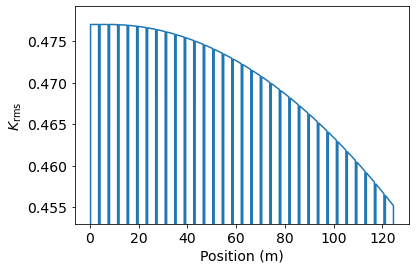

In [34]:
def plotunds(records=records,legendQ=True,merge_plots=False,figsize=None):
    if figsize != None:
#         plt.figure(figsize = figsize) # default is (6,4)
        plt.gcf().set_size_inches(figsize[0], figsize[1], forward=True)
    maxaw = 0.; minaw = 1e6;
    for rec in records:
        maxaw = np.max([np.max(record['awlist']),maxaw])
        minaw = np.min([np.min(record['awlist'][record['awlist']>0]),minaw])
        if legendQ:
            plt.plot(record['zlist'],record['awlist'],label=record['g'].input['outputfile'])
        else:
            plt.plot(record['zlist'],record['awlist'])
    plt.xlabel('Position (m)'); plt.ylabel('$K_\mathrm{rms}$')
    daw = maxaw - minaw; plt.ylim([minaw-0.1*daw,maxaw+0.1*daw]);
    if legendQ: plt.legend()
    if not merge_plots:
        figpath = os.path.join(plotsdir,'unds.png')
        try:
            plt.savefig(figpath,bbox_inches='tight')
        except:
            print('WARNING: Could not save figure to', figpath)
        plt.show()
# plotunds(records,legendQ=True)
plotunds(records,legendQ=False)

/sdf/group/ard/sw/conda2/envs/cavity/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/sdf/group/ard/sw/conda2/envs/cavity/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/sdf/group/ard/sw/conda2/envs/cavity/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater


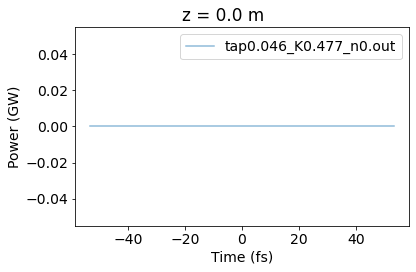

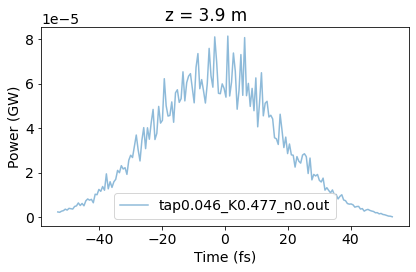

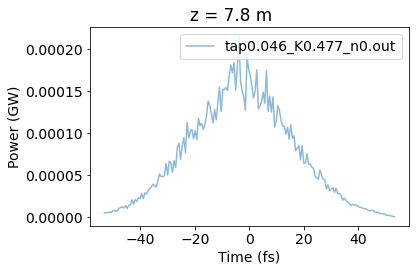

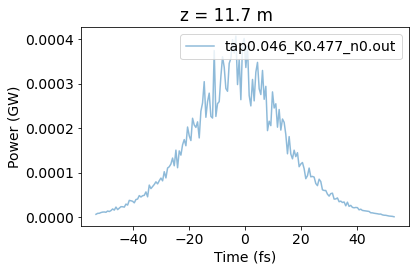

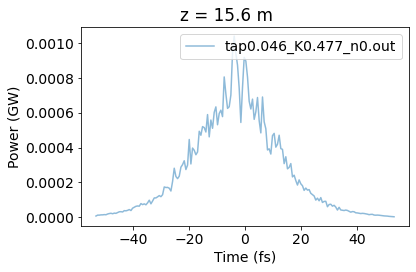

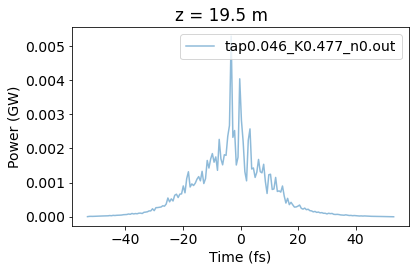

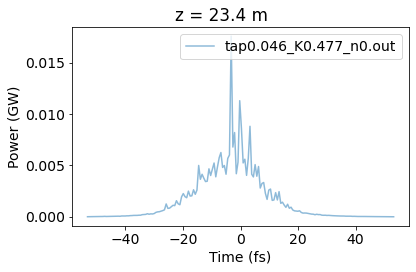

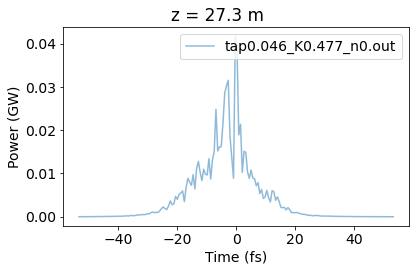

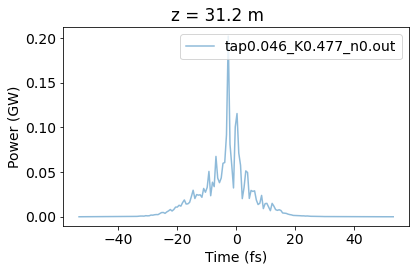

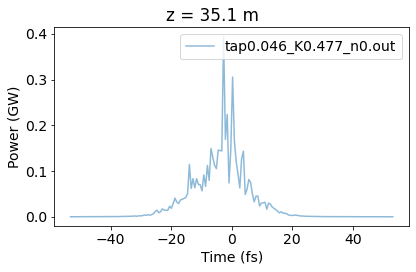

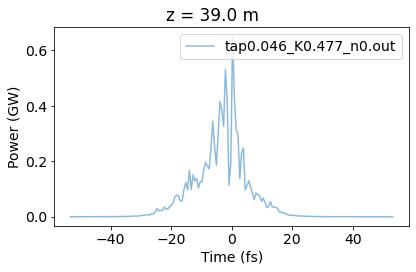

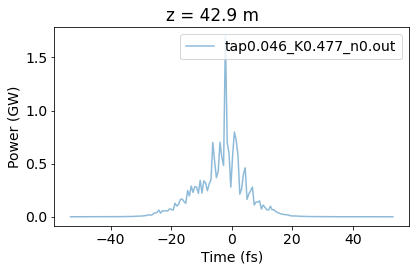

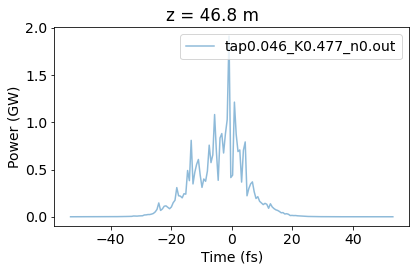

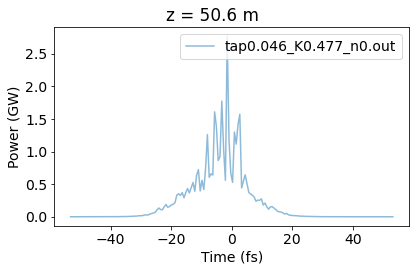

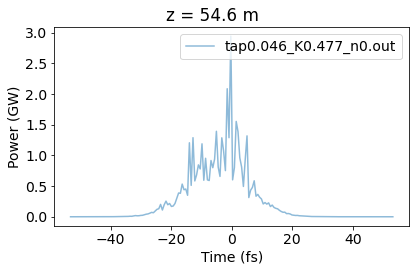

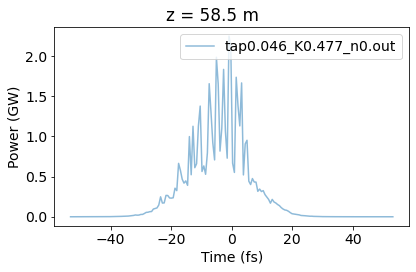

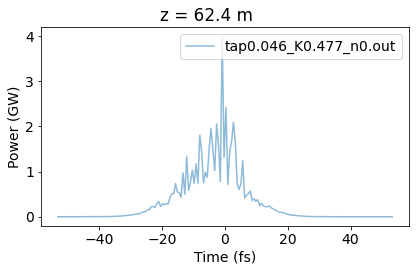

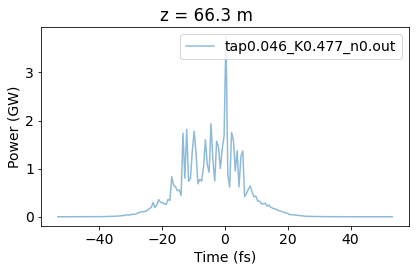

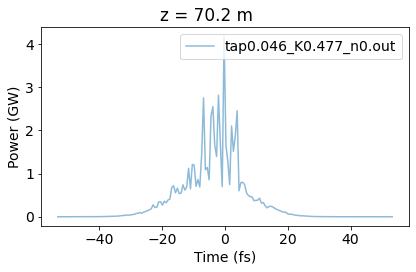

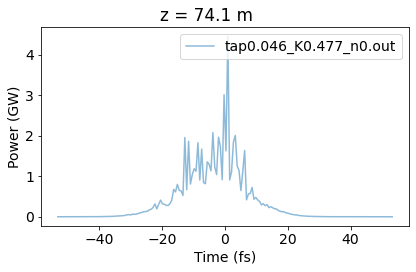

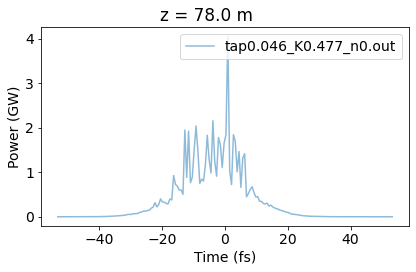

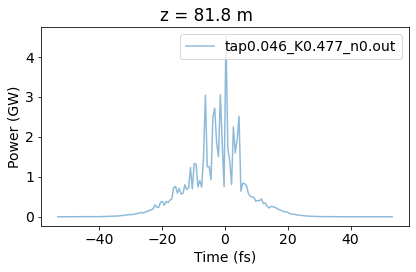

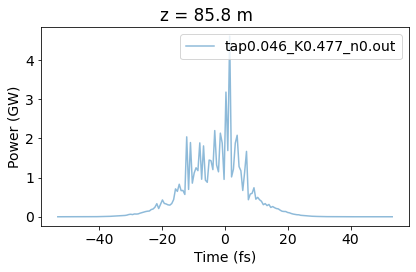

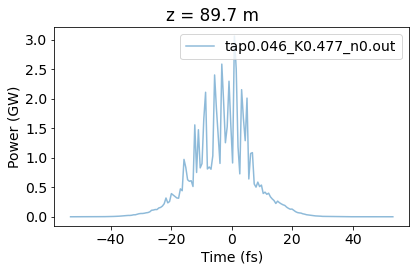

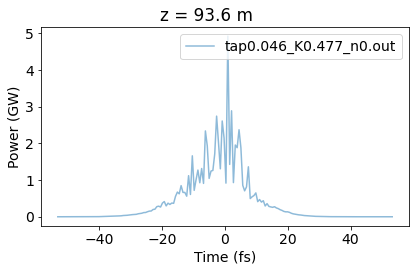

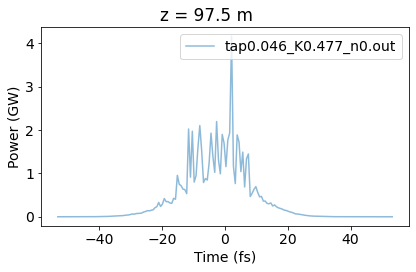

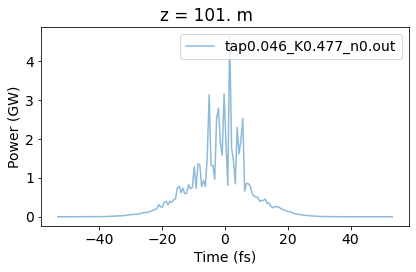

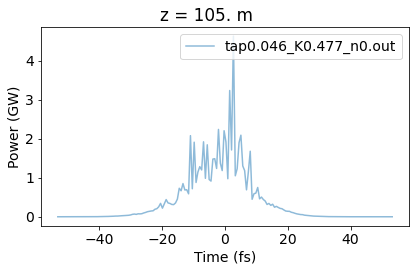

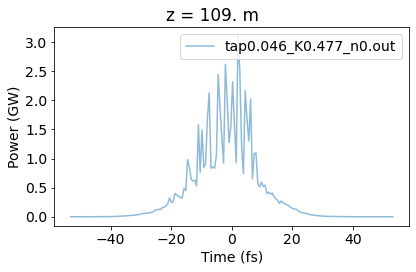

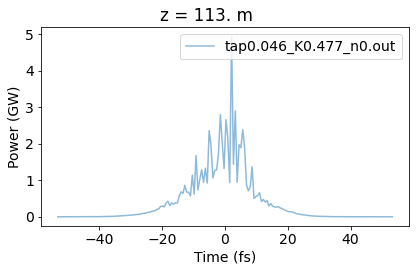

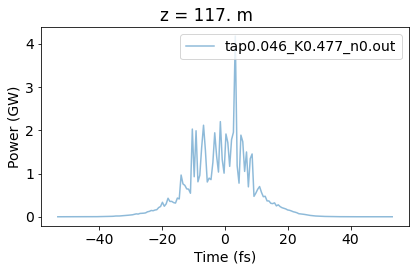

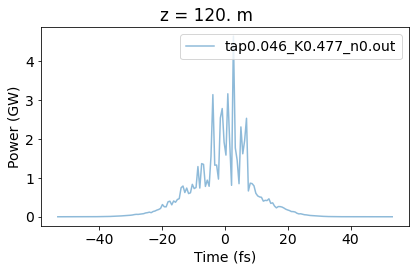

In [35]:
def get_powers(z,record):
    iz = np.argmin(np.abs(record['zlist']-z))
    rz = record['zlist'][iz]
    zg = record['zgroups'].get_group(rz)
    s = np.array(zg.slice) * g.input['xlamds'] / 3e8 * g.input['zsep']
    return s,np.array(zg.power)

def plot_powers(z,records,xlim=None,merge_plots=False,figsize=None):
    pows = []
    count = 0
    sfwhmlist = []
    if figsize != None:
#         plt.figure(figsize = figsize) # default is (6,4)
        plt.gcf().set_size_inches(figsize[0], figsize[1], forward=True)
    for rec in records:
        count += 1
        sl,pl = get_powers(z,rec); pows +=[pl]
        sl -= np.mean(sl)
        pdf = pl / (np.sum(pl))
        smean = np.sum(pdf * sl)
        s2mean = np.sum(pdf * sl**2)
        srms = np.sqrt(s2mean - smean**2)
        cdf = np.cumsum(pdf)
        smed = np.interp(0.5, cdf, sl); 
        s50=smed
        s10 = np.interp(0.1, cdf, slist_fs)
        s90 = np.interp(0.9, cdf, slist_fs)
        
        relpdf = pdf/max(pdf)
        slist50s = sl[relpdf > 0.5]*1e15
        slist10s = sl[relpdf > 0.1]*1e15
    
        #sfwhmlist += [max(slist50s) - min(slist50s)] 
        #print(files[count-1].split('/')[-1]+' FWHM of power ',sfwhmlist[-1],' fs')
        
        plt.plot(sl*1e15,pl*1e-9,alpha=0.5,label = files[count-1].split('/')[-1])
    #lens = [len(el) for el in pows]
    #pows = [pow[:min(lens)] for pow in pows]
    #mp = np.mean(pows, axis=0)*1e-9
    #plt.plot(slist_fs[:len(mp)]-np.mean(slist_fs),mp,color='k')
        if xlim != None: plt.xlim(xlim)
        plt.xlabel('Time (fs)')
        plt.ylabel('Power (GW)')
        title = 'z = ' + str(z)[:4] + ' m       '
        #title += 'FWHM = '+str(np.int(sfwhmlist[-1]*10)*0.1)[:5]+' fs'
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        figpath = os.path.join(savefolder,'power_many_z'+str(np.int())+'.png')
        if not merge_plots:
            try:
                plt.savefig(figpath,bbox_inches='tight')
            except:
                print('WARNING: Could not save figure to', figpath)
    #         plt.savefig(savefolder+'/'+fnhead+'_output_power_many.png', bbox_inches='tight')
            if showPlotQ: plt.show(); 
            plt.close()
    
Lund = 3.9
nund = np.int(max(zlist)/Lund)
for z in np.arange(nund)*Lund:
    plot_powers(z,records,figsize=(6,4), merge_plots=False)

/sdf/group/ard/sw/conda2/envs/cavity/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


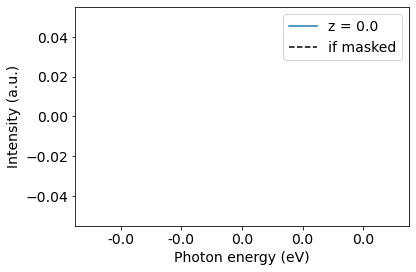

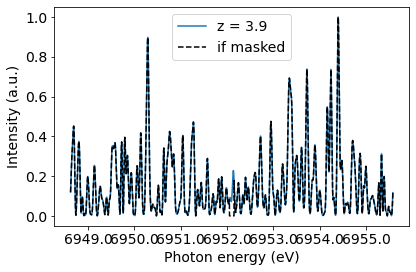

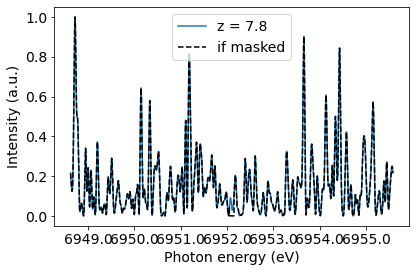

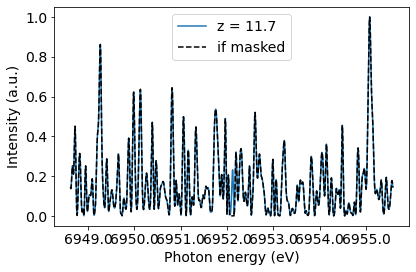

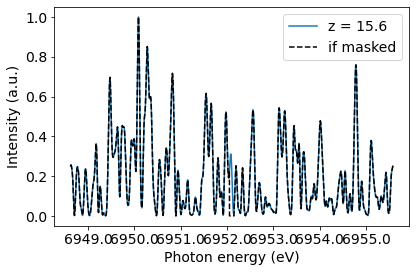

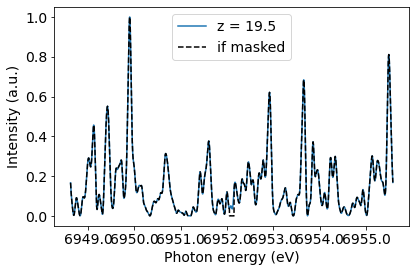

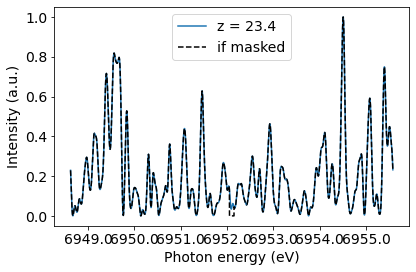

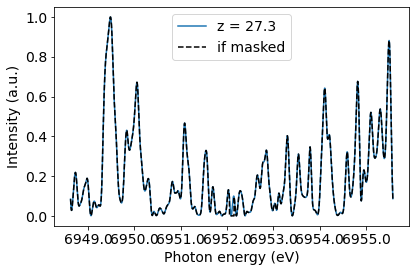

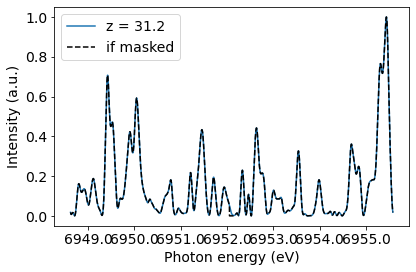

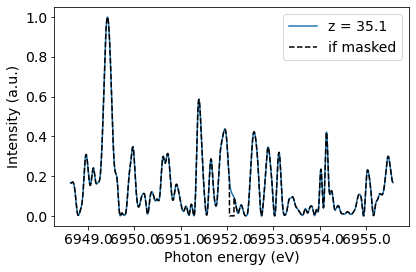

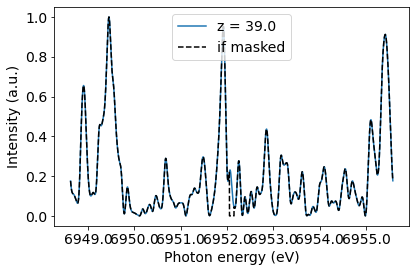

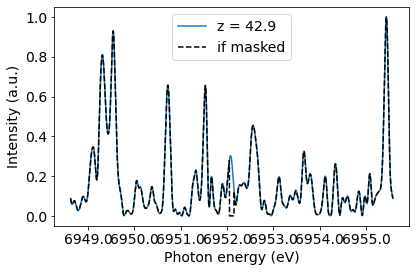

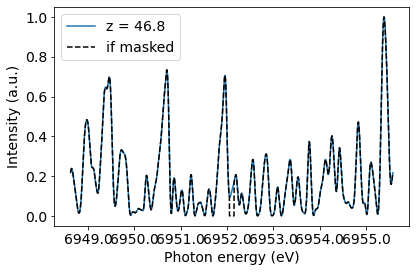

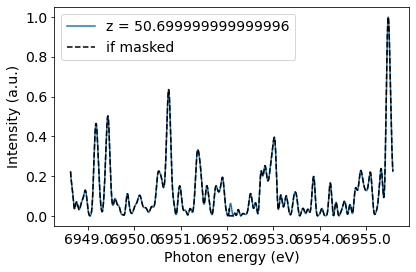

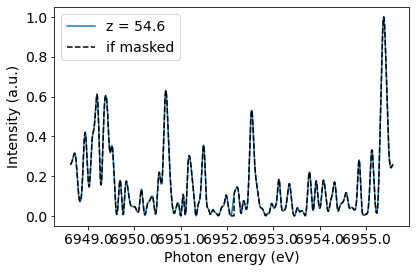

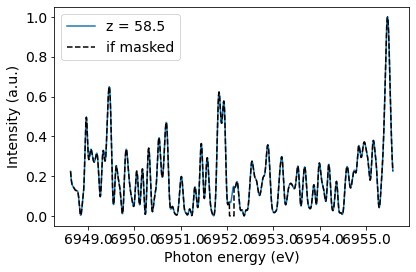

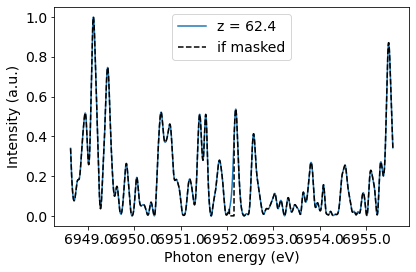

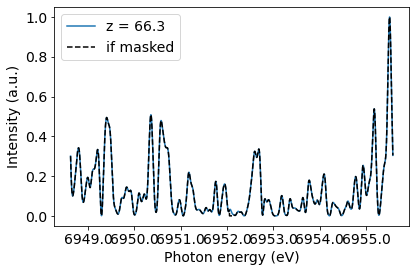

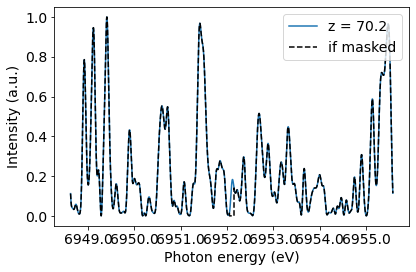

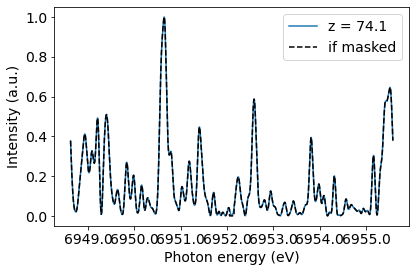

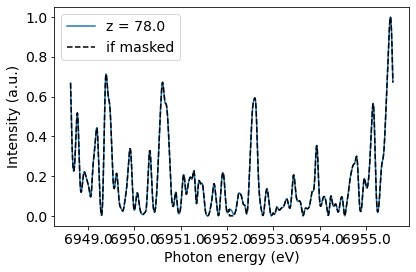

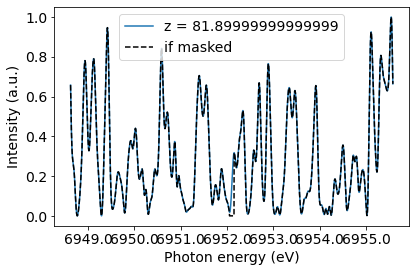

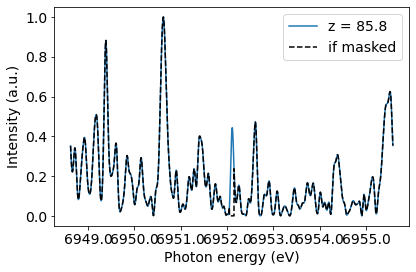

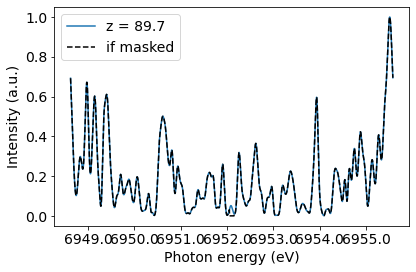

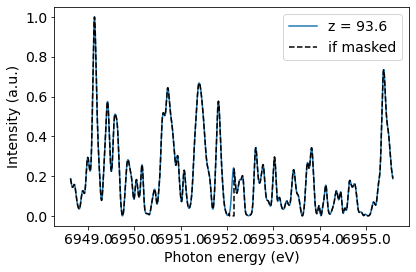

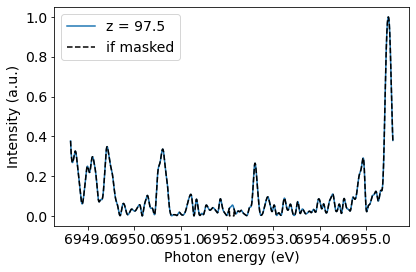

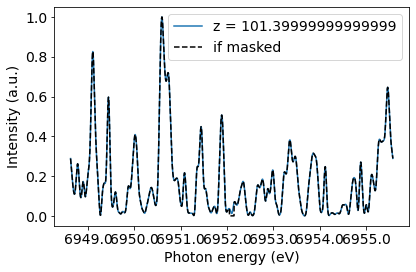

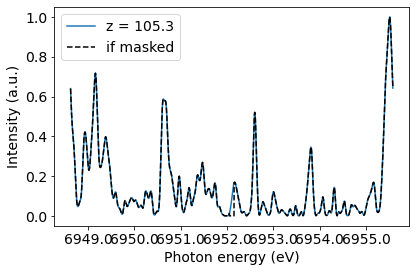

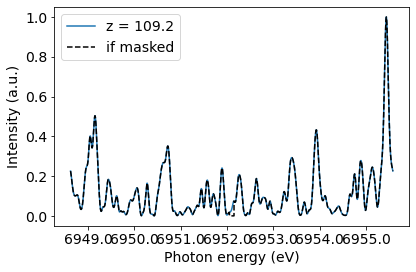

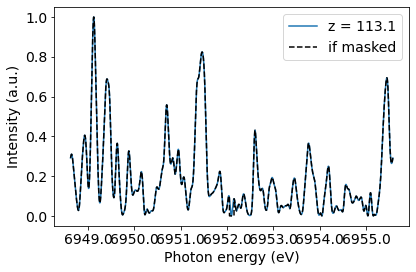

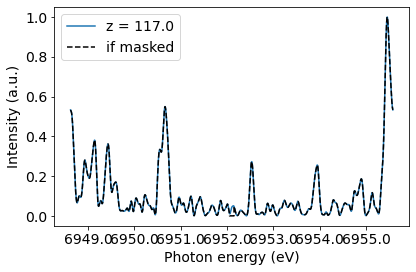

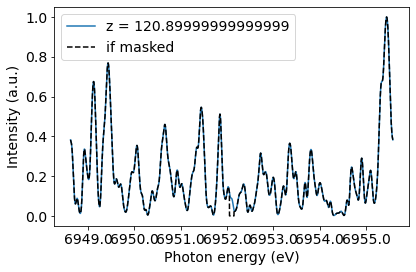

In [36]:
def get_spectra(z, record, mask_width_eV=None, mask_center_eV=None, npad = 8000):
    iz = np.argmin(np.abs(record['zlist']-z))
    rz = record['zlist'][iz]
    zg = record['zgroups'].get_group(rz)
    dt = g.input['xlamds'] / 3e8 * g.input['zsep']
    temp = np.array(zg.slice)
    sep = temp[1] - temp[0]
    s = np.array(zg.slice) * dt
    pmid = np.array(zg.p_mid); phimid = np.array(zg.phi_mid)
    s_fs = s*1e15
    
    s2 = np.arange(s.shape[0] + 2*npad) * dt*sep
    s_fs2 = s2*1e15
    
    
    h_Plank = 4.135667696e-15
    c_speed  = 299792458
   
    ws = np.arange(s_fs2.shape[0]) / (s_fs2[-1] - s_fs2[0])
    ws -= np.mean(ws)
    hw0 = h_Plank * c_speed/g.input['xlamds']
    hws = h_Plank*1e15 * ws + hw0
    

    if mask_center_eV == None:
        mask_center_eV = hw0
    if mask_width_eV == None:
        useMask = False
        mask_width_eV = 100e-3
    else:
        useMask = True
    
    mask = (np.abs(hws - mask_center_eV) > 0.5 * mask_width_eV) * 1.

    
    field = np.sqrt(pmid) * np.exp(1j * phimid) # units sqrt(GW/um^2)
    field = np.pad(field, (npad, npad))
    ftfld = np.fft.fftshift(np.fft.fft(field))
    spectra = np.abs(ftfld)**2
    spectra /= np.max(spectra)
    
    if useMask:
        shot_fluence_uJperum2 = np.sum(spectra) * (hws[1] - hws[0])
        transmitted_shot_fluence_uJperum2 = np.sum(mask * spectra) * (hws[1] - hws[0])
        netrm = np.around(shot_fluence_uJperum2-transmitted_shot_fluence_uJperum2,2)
        pctrm = np.around(100.*(1.-transmitted_shot_fluence_uJperum2/shot_fluence_uJperum2),2)
        #print('Mask removes',pctrm,'%)')
        return hws, spectra, mask, netrm, pctrm
    else:
        return hws, spectra

def plot_spectra(z,records,mask_width_eV=100e-3,xlim=None,ylim = None,merge_plots=False,figsize=None):
    pows = []
    if figsize != None:
        #plt.figure(figsize = figsize) # default is (6,4)
        plt.gcf().set_size_inches(figsize[0], figsize[1], forward=True)
    count = 0
    for rec in records:
        count += 1
        sl,pl,mask,netrm,pctrm = get_spectra(z,rec,mask_width_eV=mask_width_eV); pows +=[pl]
        #sl -= np.mean(sl)
        label_prefix = files[count-1].split('/')[-1]
        label_prefix = ''
        plt.plot(sl,pl,alpha=1,label = 'z = '+str(z))#label = label_prefix + 'in cavity')
        plt.plot(sl,pl*mask,alpha=1,label = label_prefix + 'if masked', color = 'k',linestyle='dashed')
        ax = plt.gca()
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        #hw0 = 1240.e-9/g.input['xlamds']
        #plt.axvline(x = hw0 - mask_width_eV/2, linestyle = 'dashed')
        #plt.axvline(x = hw0 + mask_width_eV/2, linestyle = 'dashed')
        plt.legend()
        #plt.plot(sl,mask, alpha = 0.5, label = label_prefix + 'filter')
    lens = [len(el) for el in pows]
    pows = [pow[:min(lens)] for pow in pows]
    #mp = np.mean(pows, axis=0)
    #plt.plot(sl[:len(mp)],mp*mask,color='k')
    #plt.plot(sl[:len(mp)],mp,color='k')
    if xlim != None: plt.xlim(xlim)
    if ylim != None: plt.ylim(ylim)
#     plt.legend()
    plt.xlabel('Photon energy (eV)')
    plt.ylabel('Intensity (a.u.)')
    title = 'z = ' + str(z)[:4] + ' m       '
#     title += 'FWHM = '+str(np.int(sfwhmlist[-1]*10)*0.1)[:5]+' fs'
    title += 'Mask removes '+str(pctrm)+'%'
    #plt.title(title)
    plt.tight_layout()
#     plt.savefig(savefolder+'/'+fnhead+'_output_spectra_many.png', bbox_inches='tight')
    figpath = os.path.join(savefolder,'spectra_many_z'+str(np.int())+'.png')
    if not merge_plots:
        try:
            plt.savefig(figpath,bbox_inches='tight')
        except:
            print('WARNING: Could not save figure to', figpath)
        if showPlotQ: plt.show(); 
        plt.close()


Lund = 3.9
nund = np.int(max(zlist)/Lund)
for z in np.arange(0,nund)*Lund:
    plot_spectra(z,records,figsize=(6,4), merge_plots = False)

In [37]:
def get_pmid(z, record, mask_width_eV=None, mask_center_eV=None):
    iz = np.argmin(np.abs(record['zlist']-z))
    rz = record['zlist'][iz]
    zg = record['zgroups'].get_group(rz)
    s = np.array(zg.slice) * g.input['xlamds'] / 3e8 * g.input['zsep']
    pmid = np.array(zg.p_mid); phimid = np.array(zg.phi_mid)
    
    s_fs = s*1e15
    ws = np.arange(len(s_fs)) / (s_fs[-1] - s_fs[0])
    ws -= np.mean(ws)
    hw0 = 1240.e-9/g.input['xlamds']
    hws = 4.135 * ws + hw0

    if mask_center_eV == None:
        mask_center_eV = hw0
    if mask_width_eV == None:
        useMask = False
        mask_width_eV = 100e-3
    else:
        useMask = True
    
    mask = (np.abs(hws - mask_center_eV) > 0.5 * mask_width_eV) * 1.

    darea_m2 = (2. * g.input['dgrid'] / g.input['ncar'])**2 # area (m^2) of pixel in fld grid
    darea_mm2 = darea_m2 * 1e6
    darea_um2 = darea_mm2 * 1e6
    
    shot_fluence_uJperum2 = np.sum(pmid) * (s_fs[1] - s_fs[0]) * 1.e-15 * 1.e6 / darea_um2
    pmid *= 1e-6 * shot_fluence_uJperum2 / (s_fs[1] - s_fs[0]) / 1.e-15 * 1.e-9 / np.sum(pmid) # units GW/um^2
    field = np.sqrt(pmid) * np.exp(1j * phimid) # units sqrt(GW/um^2)
    ftfld = np.fft.fftshift(np.fft.fft(field))
    spectra = np.abs(ftfld)**2
    spectra *= shot_fluence_uJperum2 / (hws[1] - hws[0]) / np.sum(spectra) # normalized: uJ/mm^2/eV
    
    if useMask:
        transmitted_shot_fluence_uJperum2 = np.sum(mask * spectra) * (hws[1] - hws[0])
        netrm = np.around(shot_fluence_uJperum2-transmitted_shot_fluence_uJperum2,2)
        pctrm = np.around(100.*(1.-transmitted_shot_fluence_uJperum2/shot_fluence_uJperum2),2)
        #print('Mask removes',netrm,'uJ/um^2 (',pctrm,'%)')
        ftfld_masked = ftfld * np.sqrt(mask)
        pmid_masked = np.abs((np.fft.ifft(np.fft.ifftshift(ftfld_masked)))**2)
        ftfld_returned = ftfld * np.sqrt(1-mask)
        pmid_returned = np.abs((np.fft.ifft(np.fft.ifftshift(ftfld_returned)))**2)
        return s, pmid, pmid_masked, pmid_returned, netrm, pctrm
    else:
        return s, pmid

def plot_pmid(z,records,mask_width_eV=100e-3,xlim=None,ylim = None,merge_plots=False,figsize=None):
    pows = []
    count = 0
    sfwhmlist = []
    pctrmlist = []
    if figsize != None:
#         plt.figure(figsize = figsize) # default is (6,4)
        plt.gcf().set_size_inches(figsize[0], figsize[1], forward=True)
    for rec in records:
        count += 1
#         sl,pl = get_powers(z,rec); 
        sl,pl,plmasked,pmid_returned,netrm,pctrm = get_pmid(z,rec,mask_width_eV=mask_width_eV); pows +=[pl]
        pows +=[pl]
        pctrmlist += [pctrm]
        sl -= np.mean(sl)
        
        pdf = pl / (np.sum(pl))
        smean = np.sum(pdf * sl)
        s2mean = np.sum(pdf * sl**2)
        srms = np.sqrt(s2mean - smean**2)
        cdf = np.cumsum(pdf)
        smed = np.interp(0.5, cdf, sl); 
        s50 = smed
        s10 = np.interp(0.1, cdf, slist_fs)
        s90 = np.interp(0.9, cdf, slist_fs)
        
        relpdf = pdf/max(pdf)
        slist50s = sl[relpdf > 0.5]*1e15
        slist10s = sl[relpdf > 0.1]*1e15
    
        sfwhmlist += [max(slist50s) - min(slist50s)] 
        print(files[count-1].split('/')[-1]+' FWHM of power ',sfwhmlist[-1],' fs')
        
        label_prefix = files[count-1].split('/')[-1]
        label_prefix = ''
        plt.plot(sl*1e15,pl,alpha=0.5,label = label_prefix+'in cavity')
        plt.plot(sl*1e15,plmasked,alpha=0.5,label = label_prefix+'if masked')
    #lens = [len(el) for el in pows]
    #pows = [pow[:min(lens)] for pow in pows]
    #mp = np.mean(pows, axis=0)*1e-9
    #plt.plot(slist_fs[:len(mp)]-np.mean(slist_fs),mp,color='k')
        if xlim != None: plt.xlim(xlim)
        plt.xlabel('Time (fs)')
        plt.ylabel('On-axis intens. (GW/um$^2$)')
        title = 'z = ' + str(z)[:4] + ' m       '
        title += 'FWHM = '+str(np.int(sfwhmlist[-1]*10)*0.1)[:5]+' fs'
        plt.title(title)
#         plt.legend()
        plt.tight_layout()
        figpath = os.path.join(savefolder,'intensity_many_z'+str(np.int())+'.png')
        if not merge_plots:
            try:
                plt.savefig(figpath,bbox_inches='tight')
            except:
                print('WARNING: Could not save figure to', figpath)
    #         plt.savefig(savefolder+'/'+fnhead+'_output_intens_many.png', bbox_inches='tight')
            if showPlotQ: plt.show(); 
            plt.close()


Lund = 3.9
nund = np.int(max(zlist)/Lund)
for z in np.arange(nund+1)*Lund:
    plot_pmid(z,records,figsize=(6,4))

/sdf/group/ard/sw/conda2/envs/cavity/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/sdf/group/ard/sw/conda2/envs/cavity/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater
/sdf/group/ard/sw/conda2/envs/cavity/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in greater


ValueError: max() arg is an empty sequence

<Figure size 432x288 with 0 Axes>

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  99.27628960000001  fs


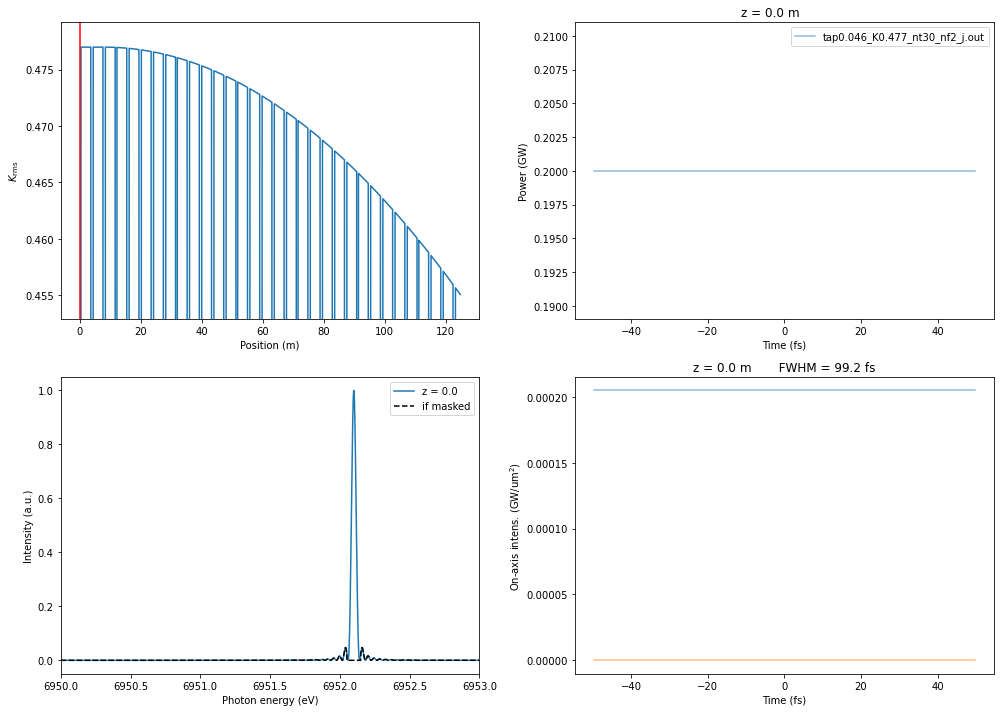

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  24.373220799999995  fs


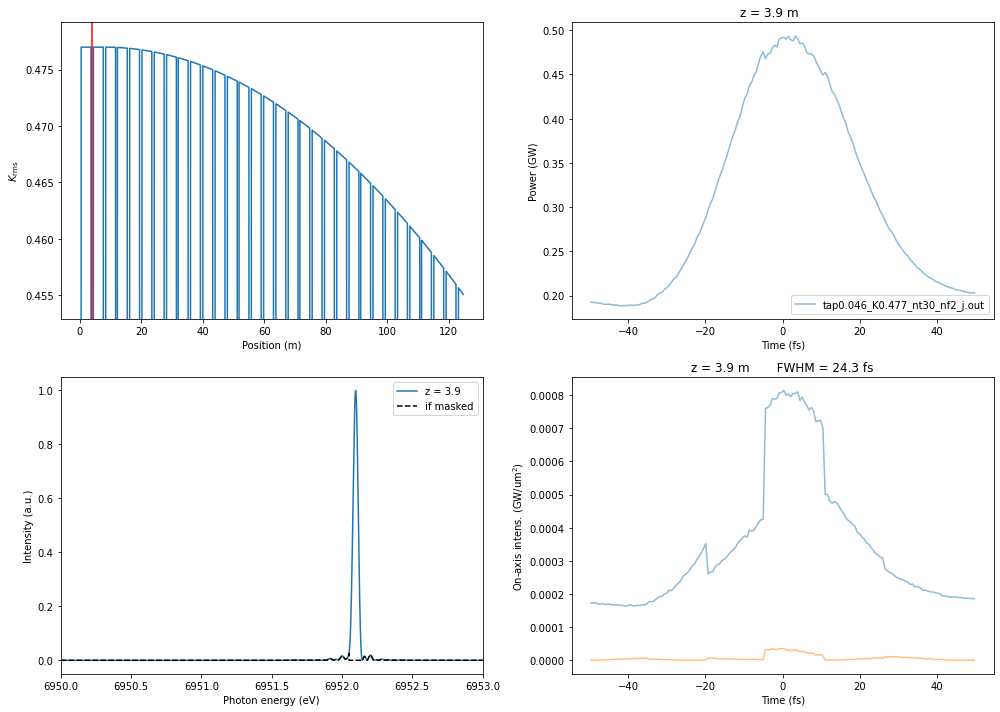

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  31.506846399999993  fs


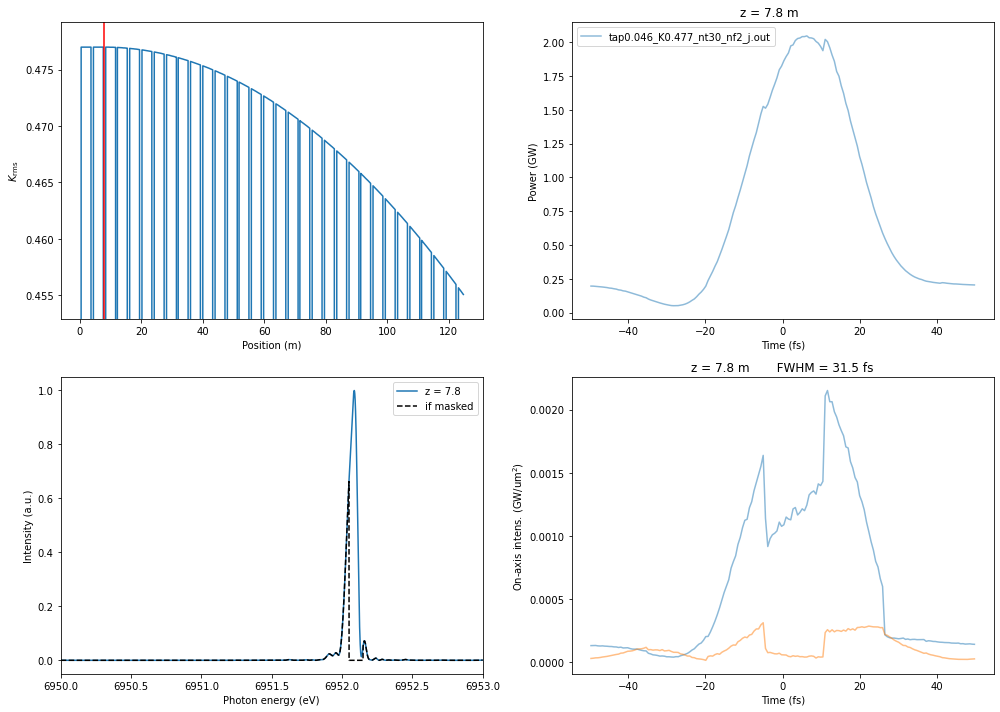

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  19.023001600000008  fs


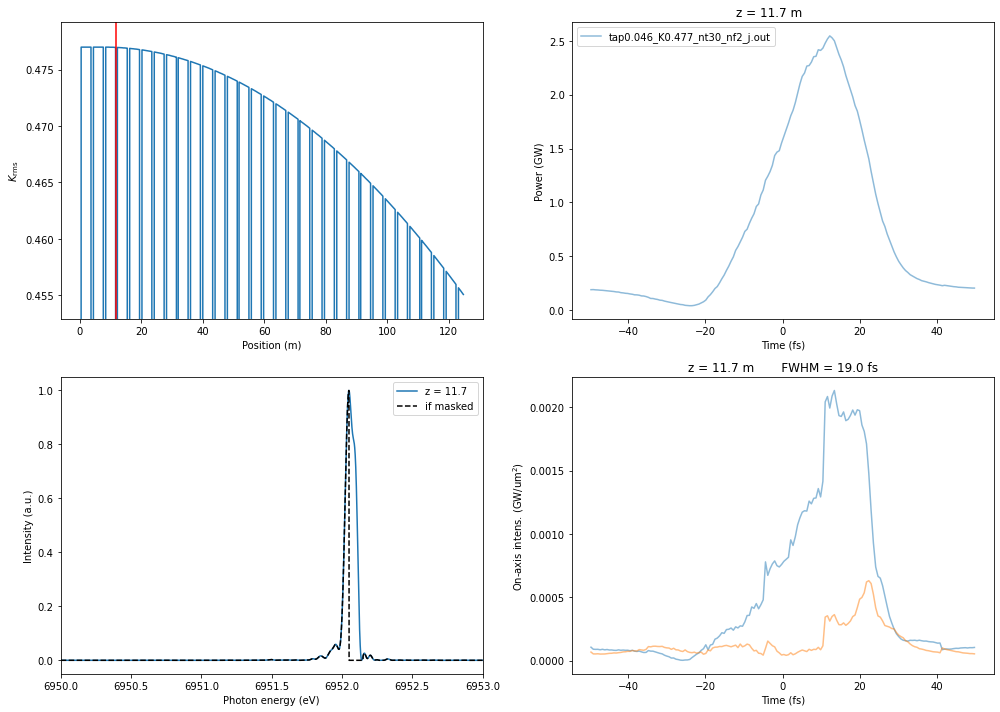

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  23.778751999999997  fs


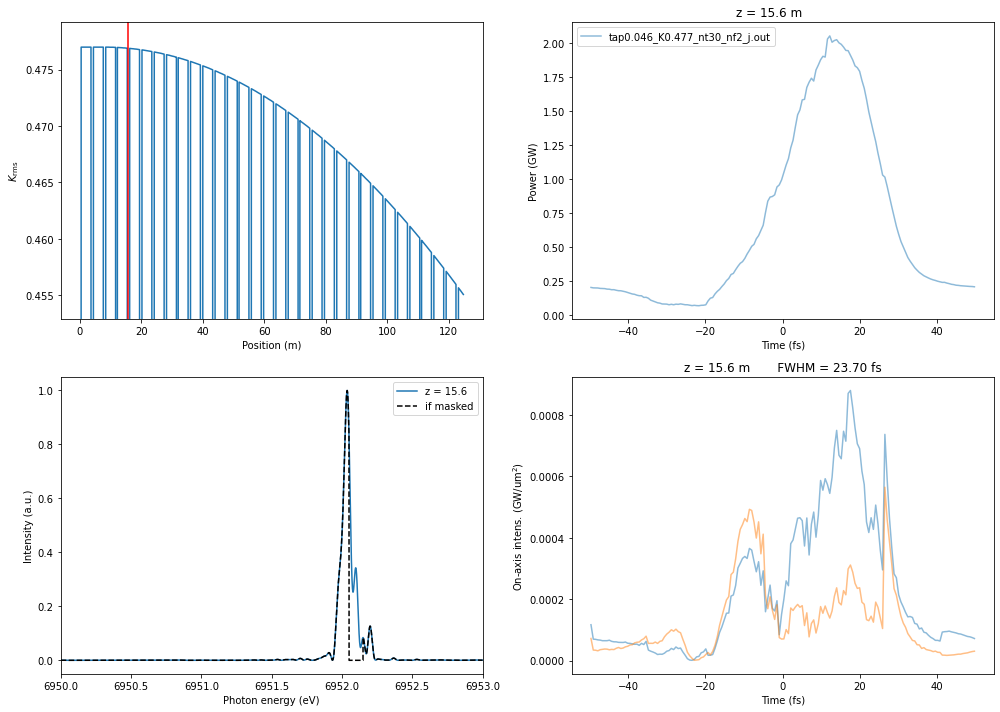

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  28.534502399999994  fs


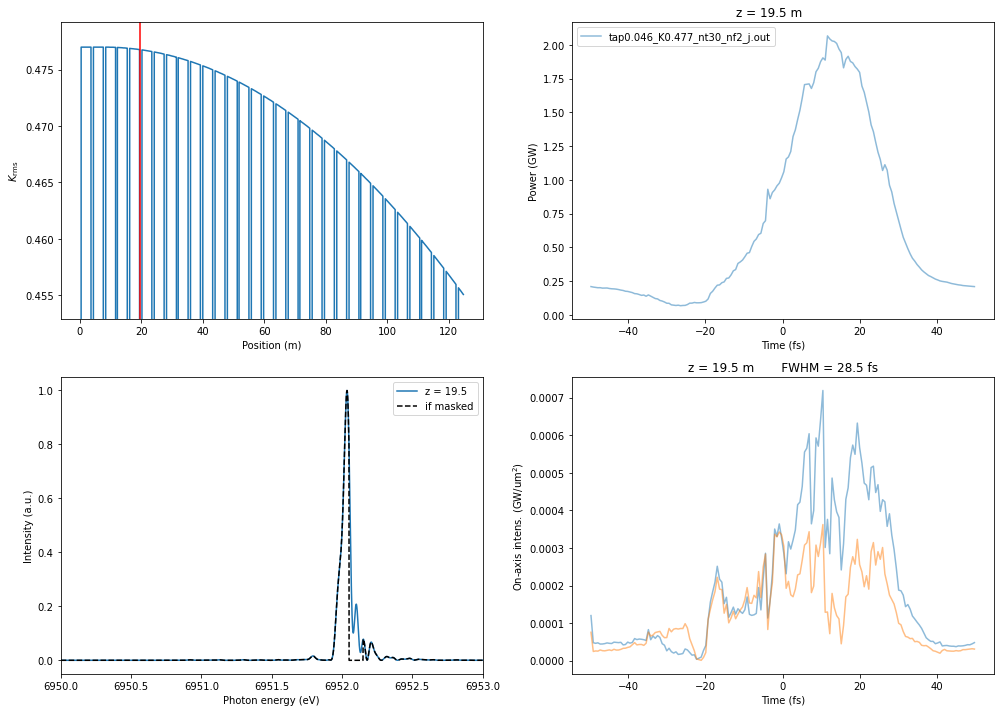

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  23.778751999999997  fs


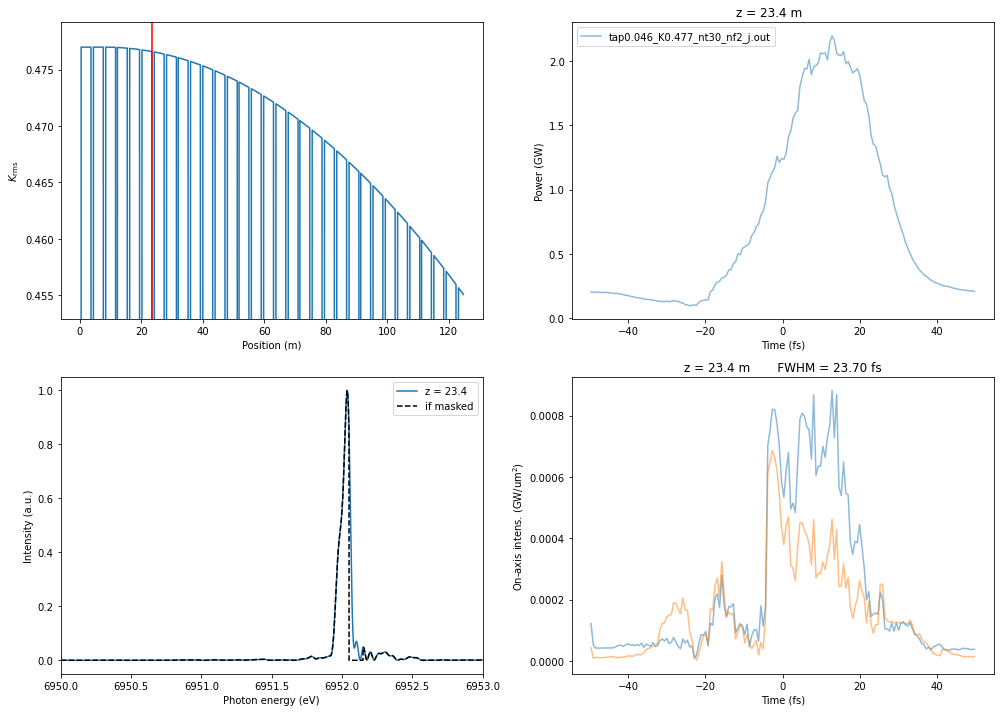

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  38.640472  fs


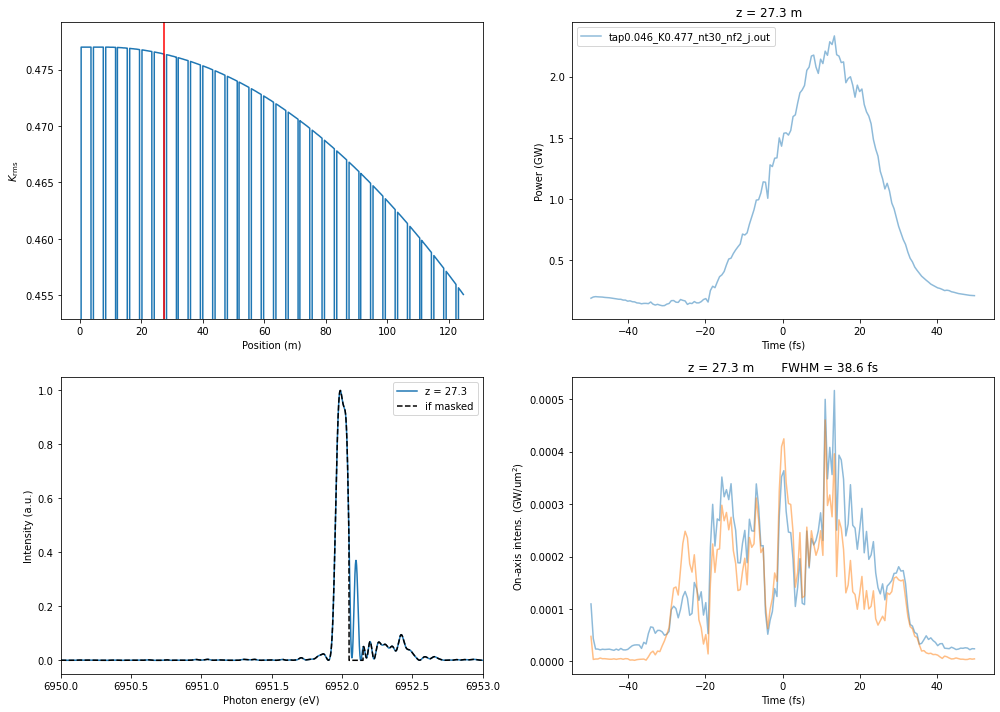

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  20.806407999999994  fs


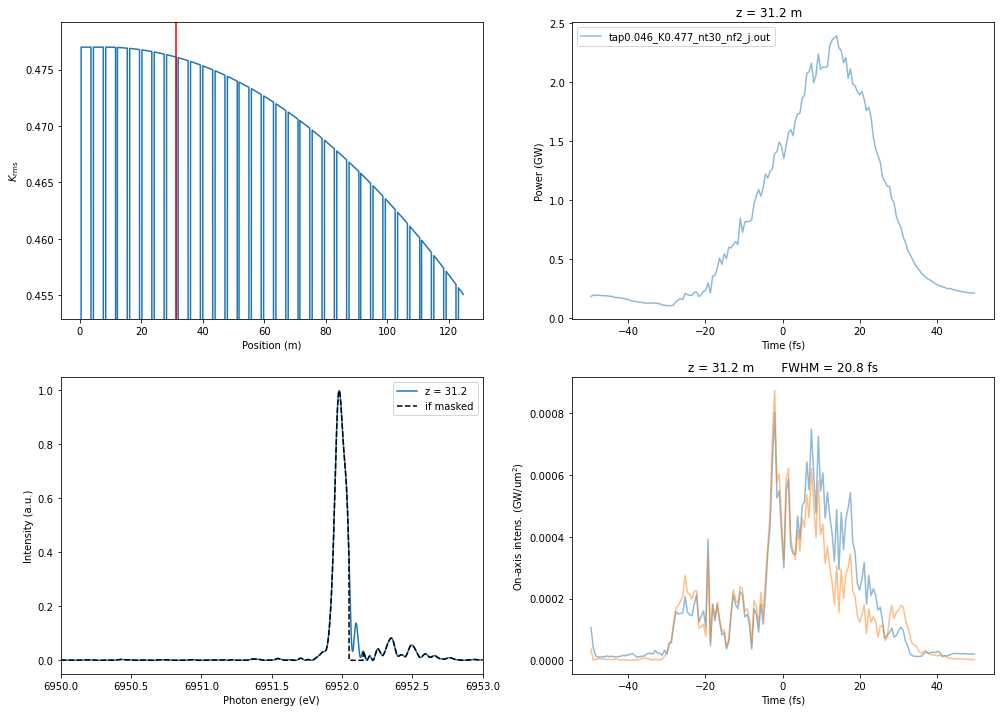

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  33.884721600000006  fs


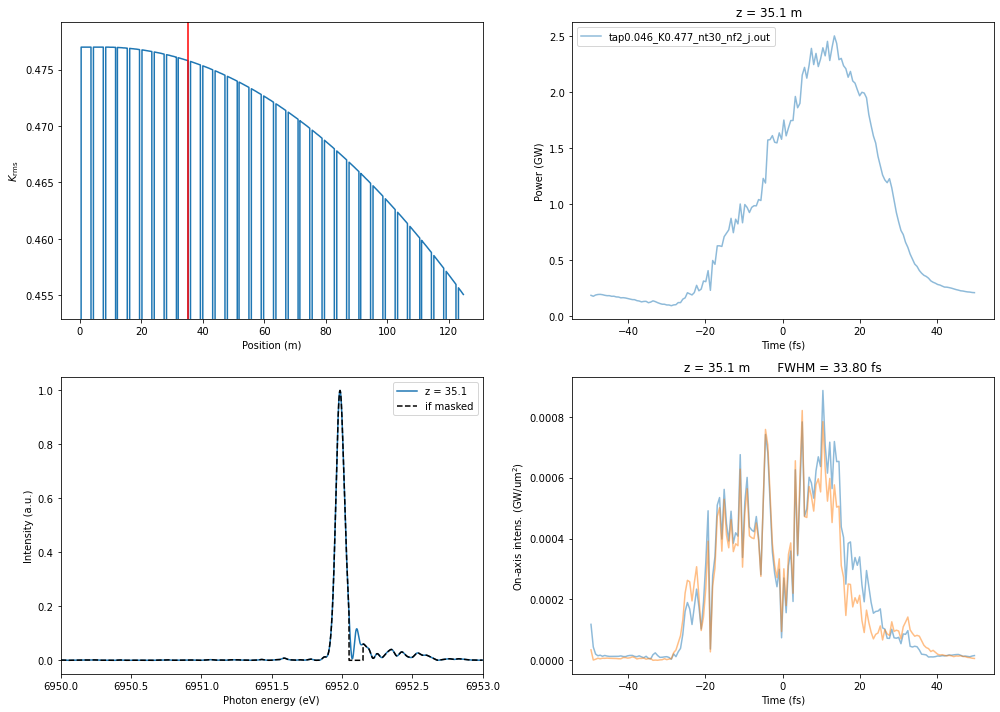

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  21.400876799999995  fs


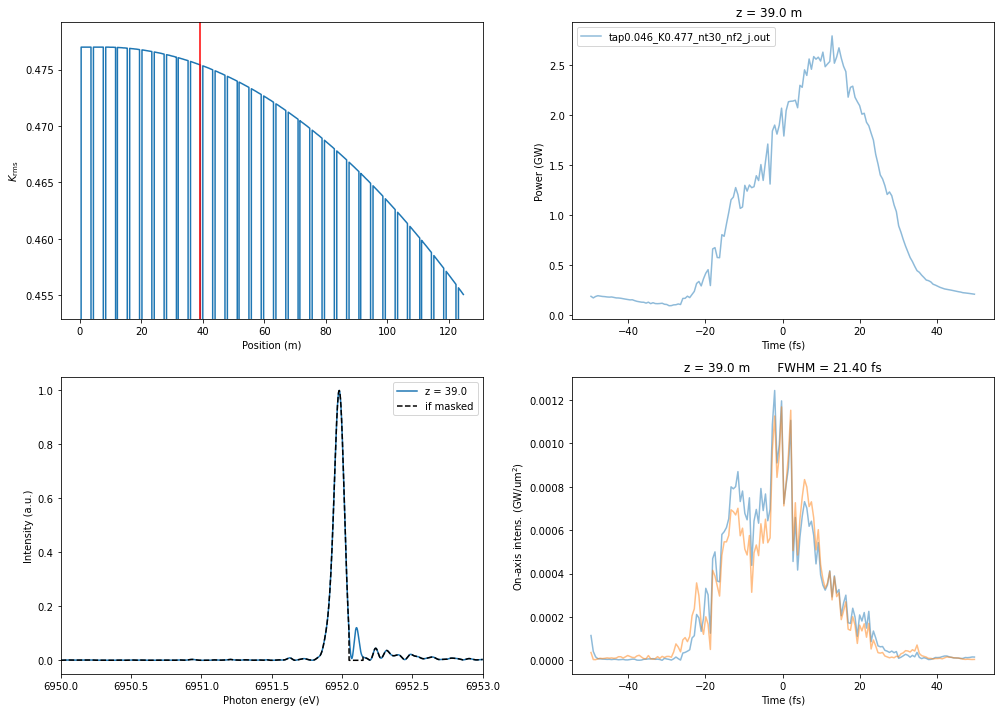

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  21.995345599999993  fs


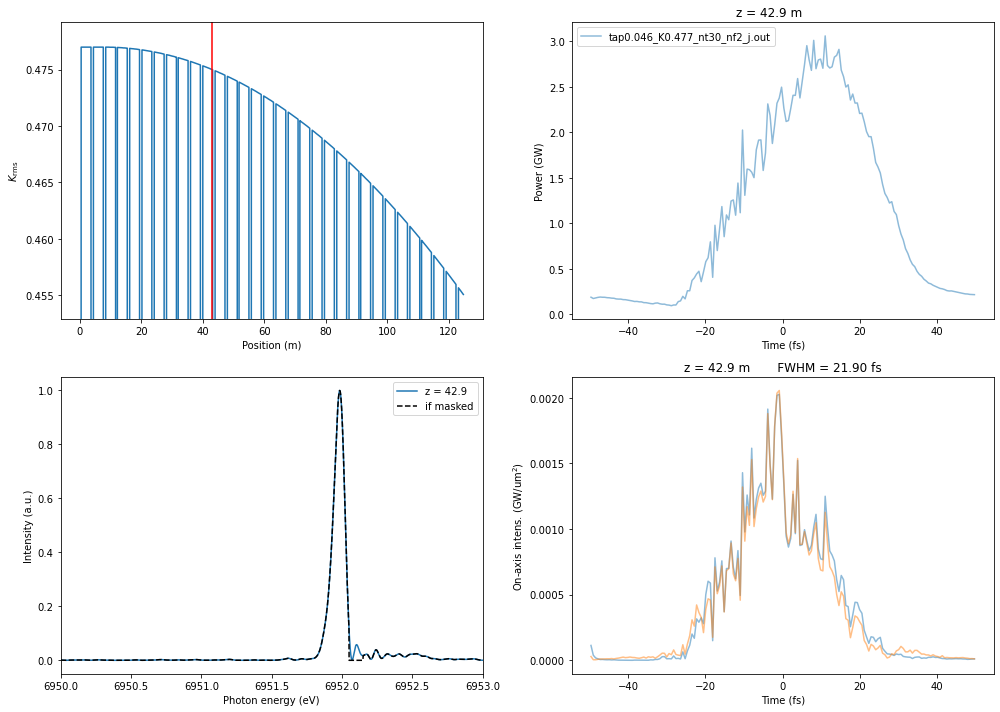

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  10.105969599999987  fs


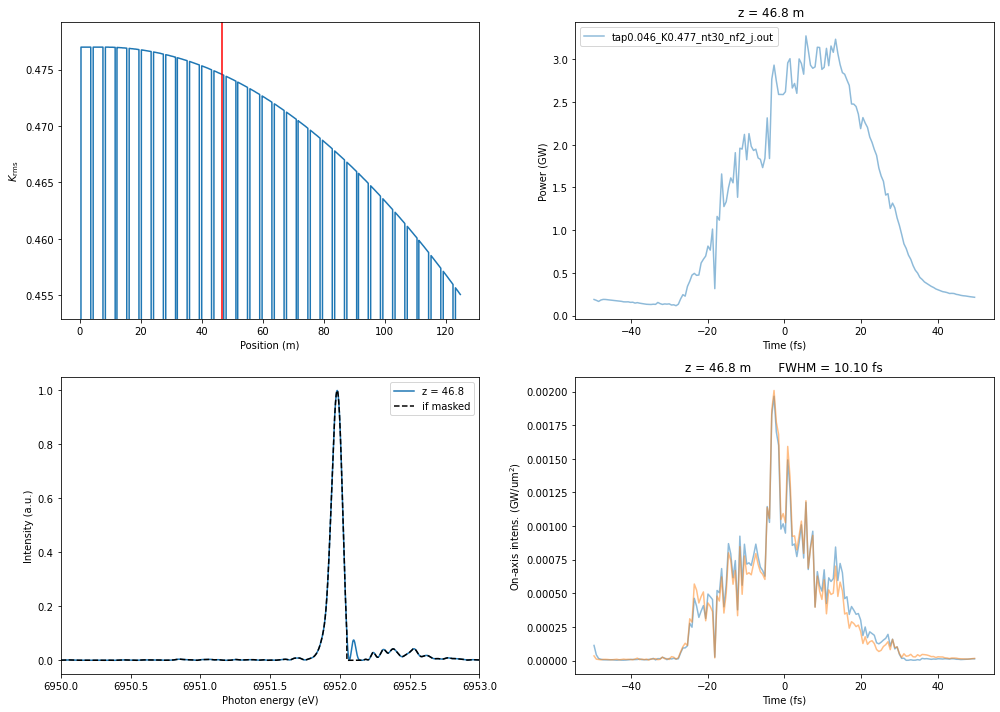

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  28.534502399999987  fs


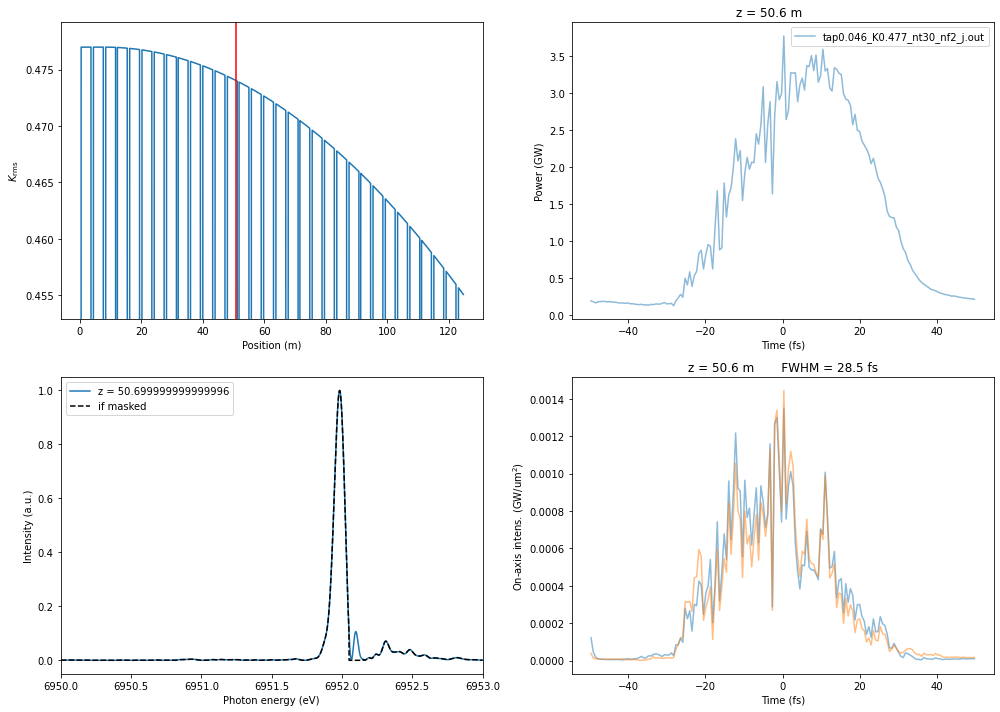

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  7.1336256  fs


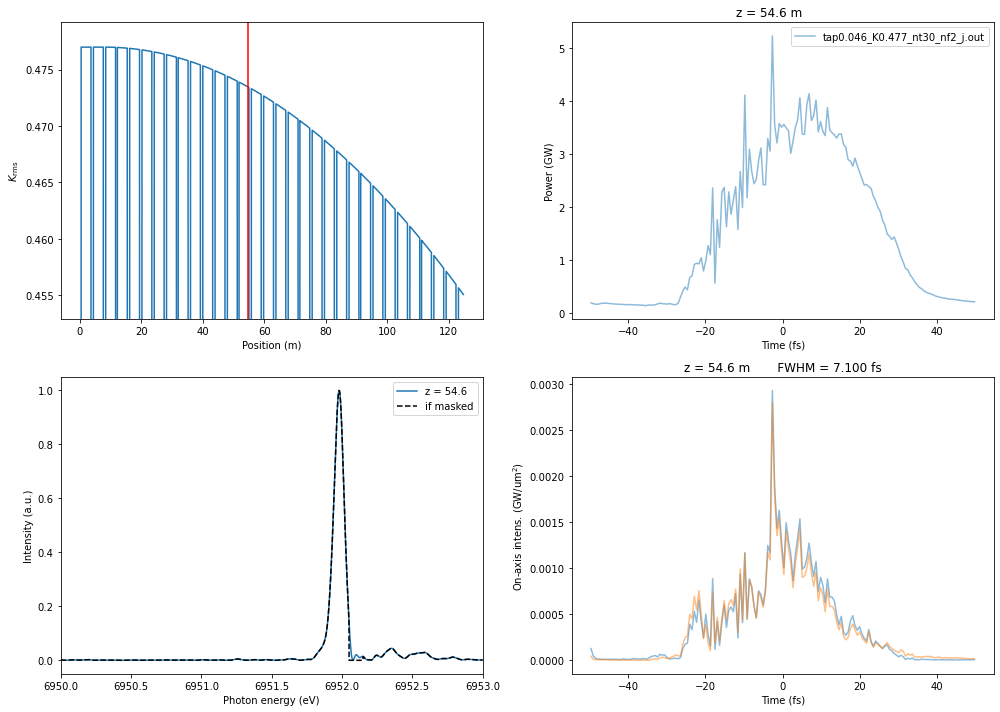

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  32.1013152  fs


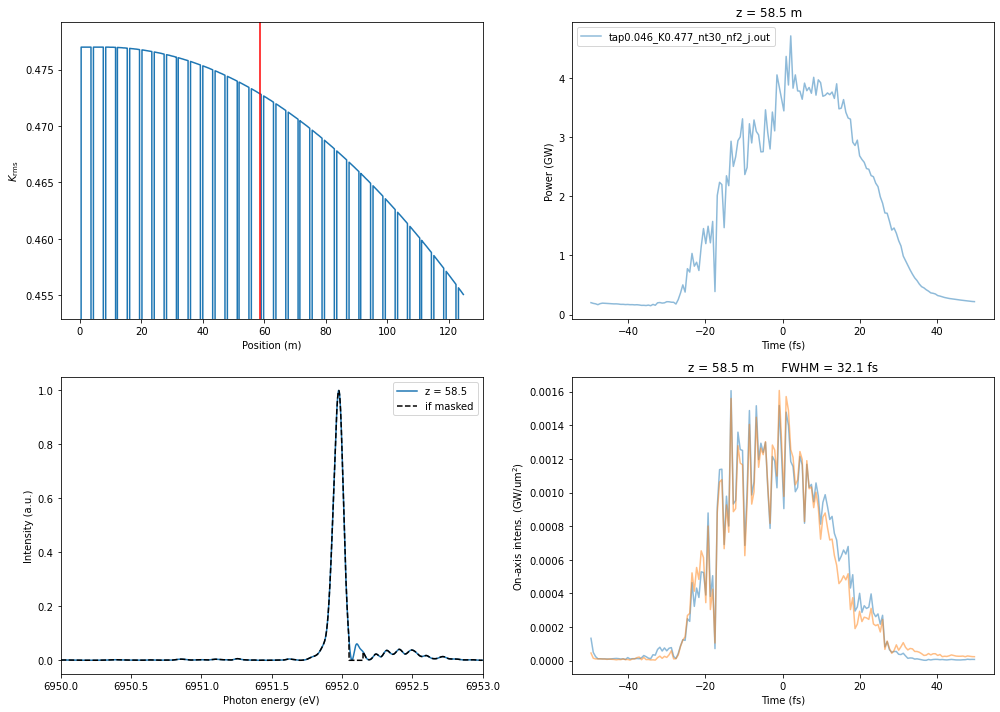

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  30.912377600000006  fs


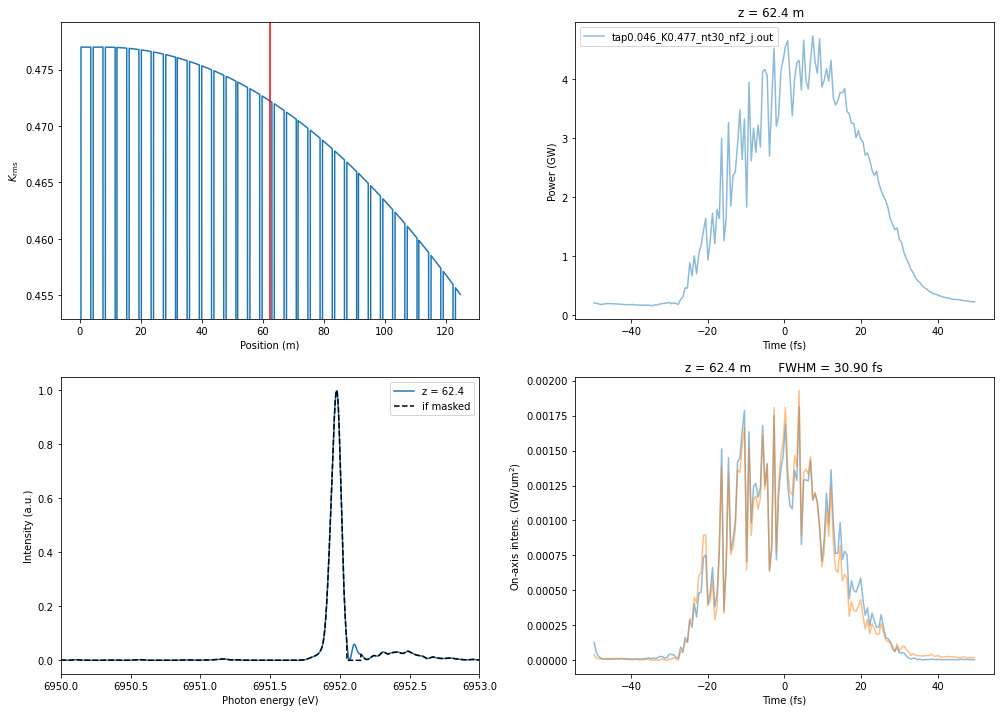

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  27.940033600000007  fs


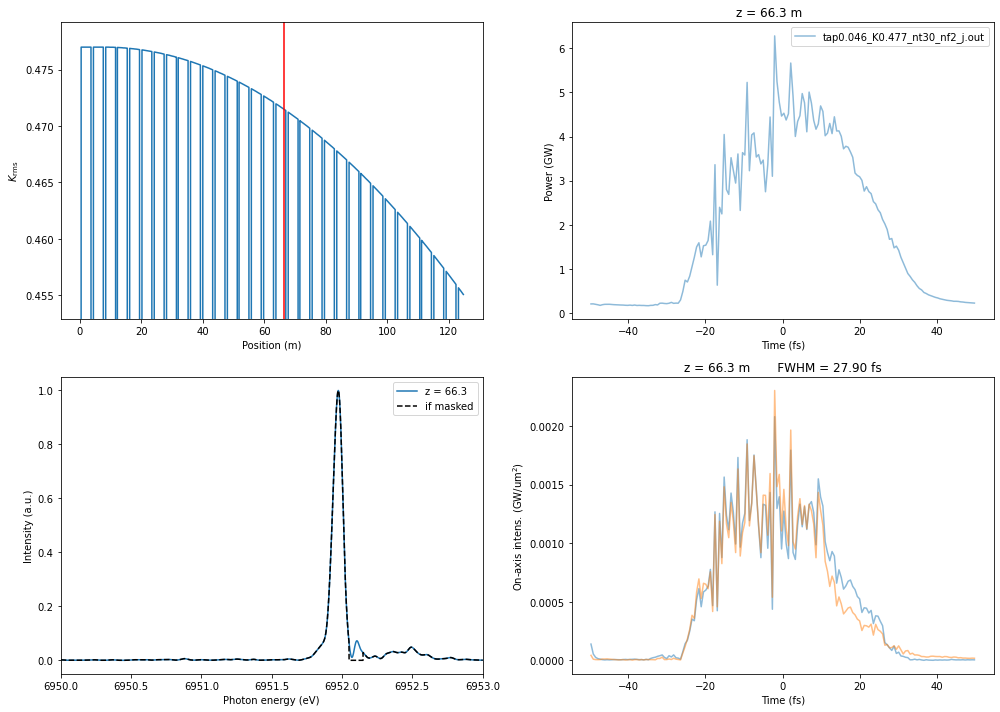

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  32.1013152  fs


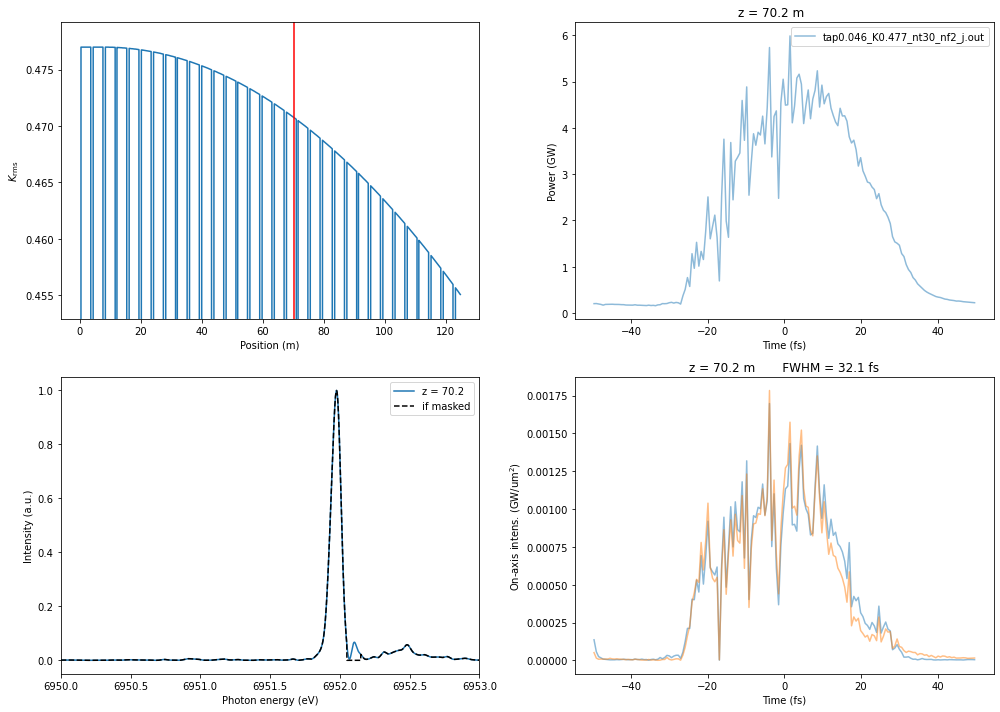

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  30.912377600000006  fs


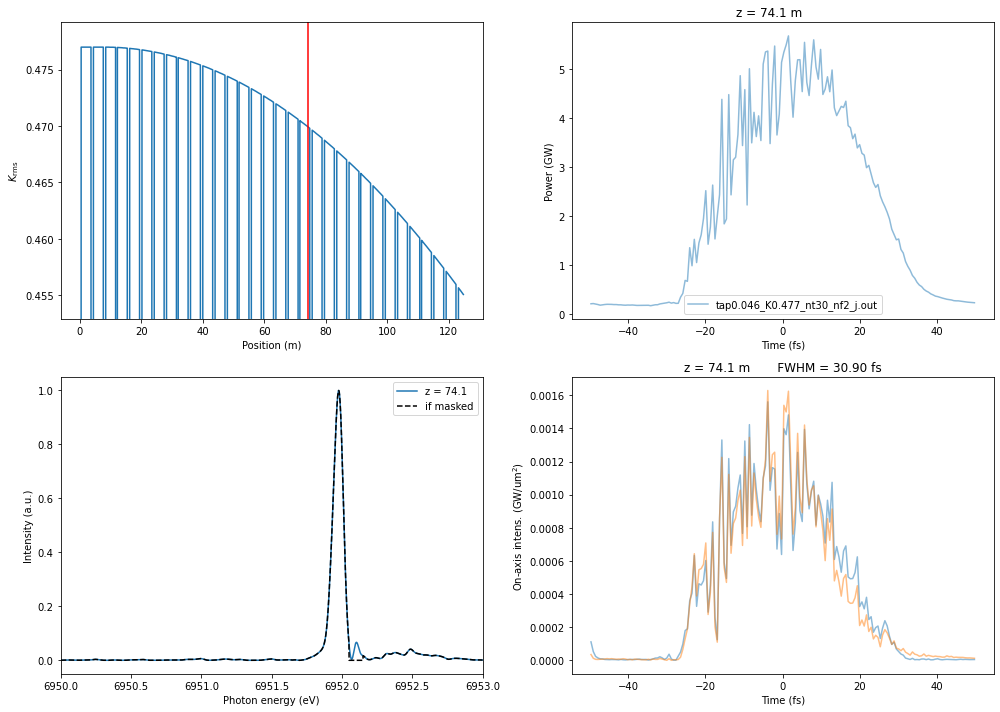

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  33.8847216  fs


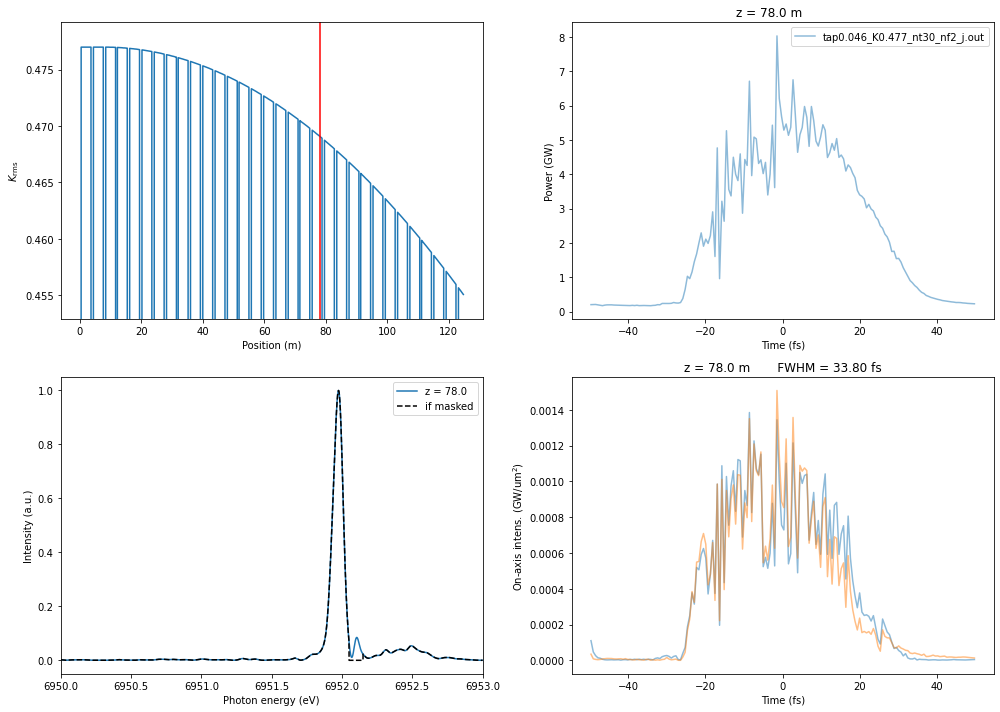

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  33.884721600000006  fs


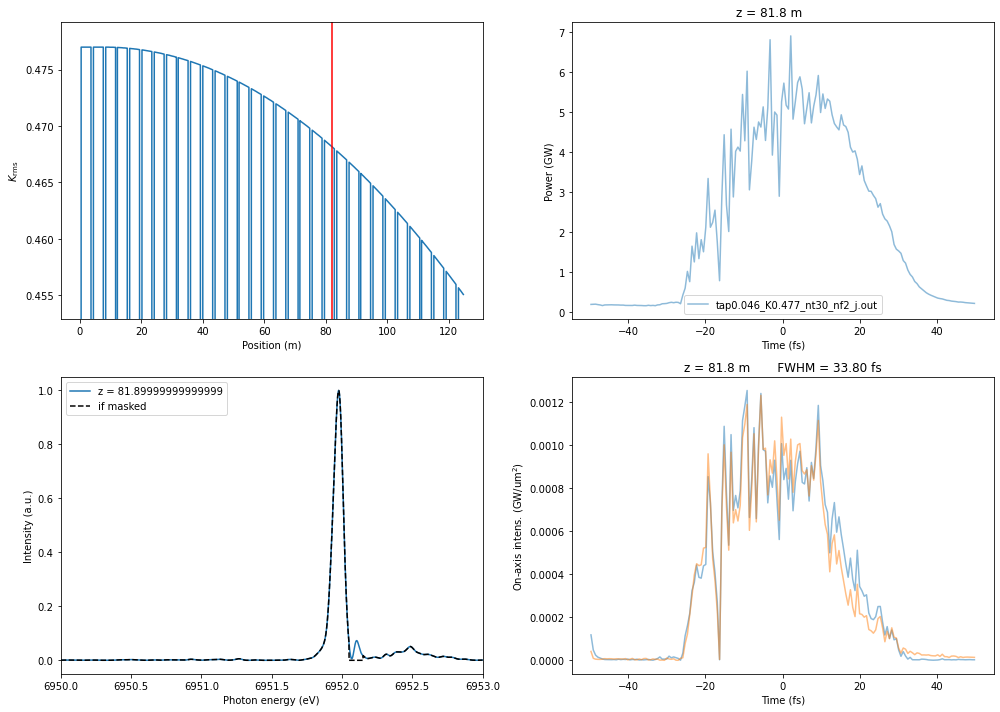

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  25.5621584  fs


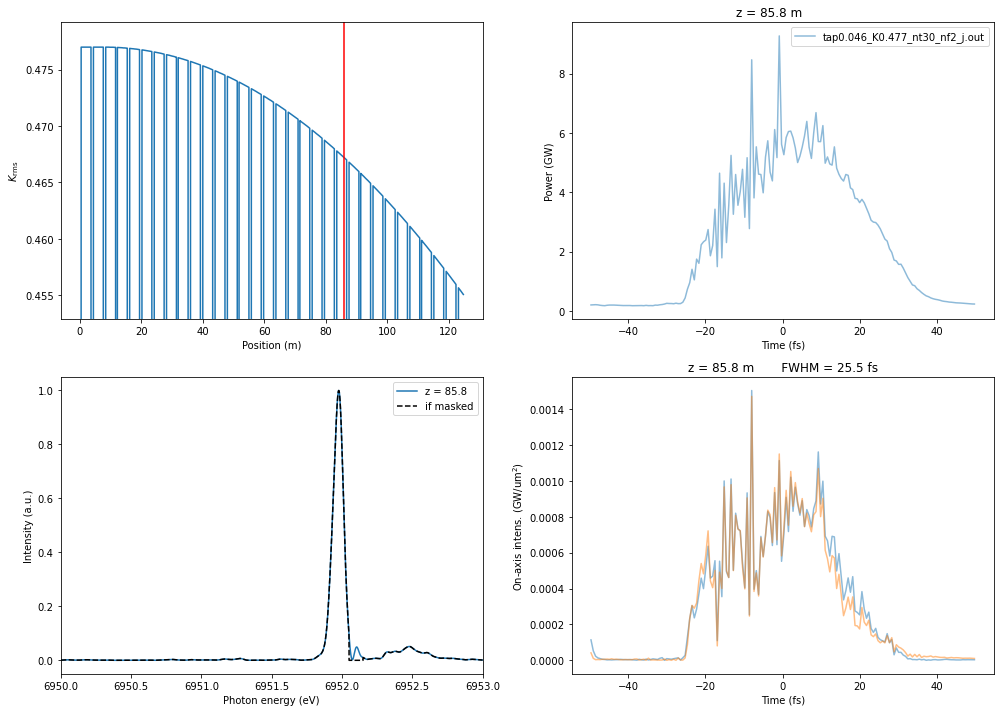

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  33.2902528  fs


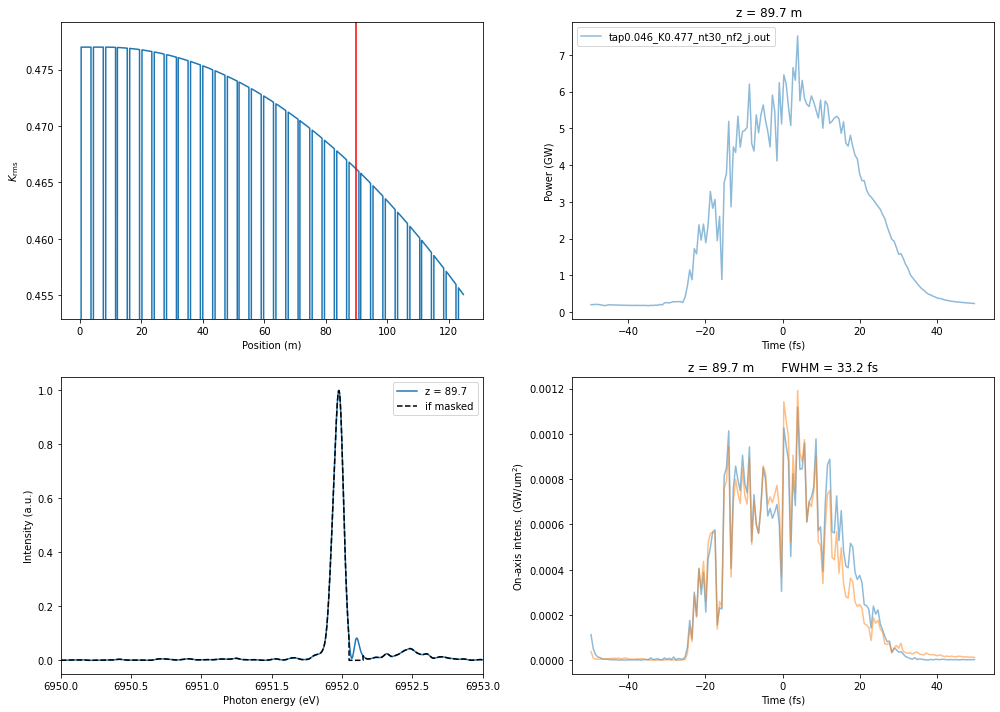

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  32.69578399999999  fs


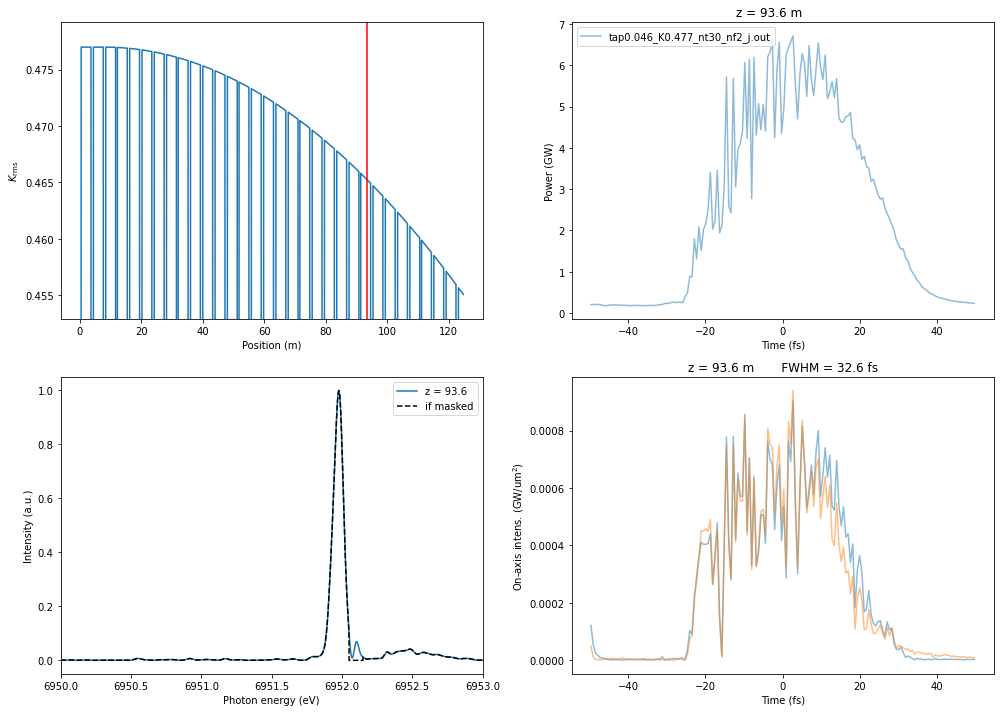

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  26.751095999999997  fs


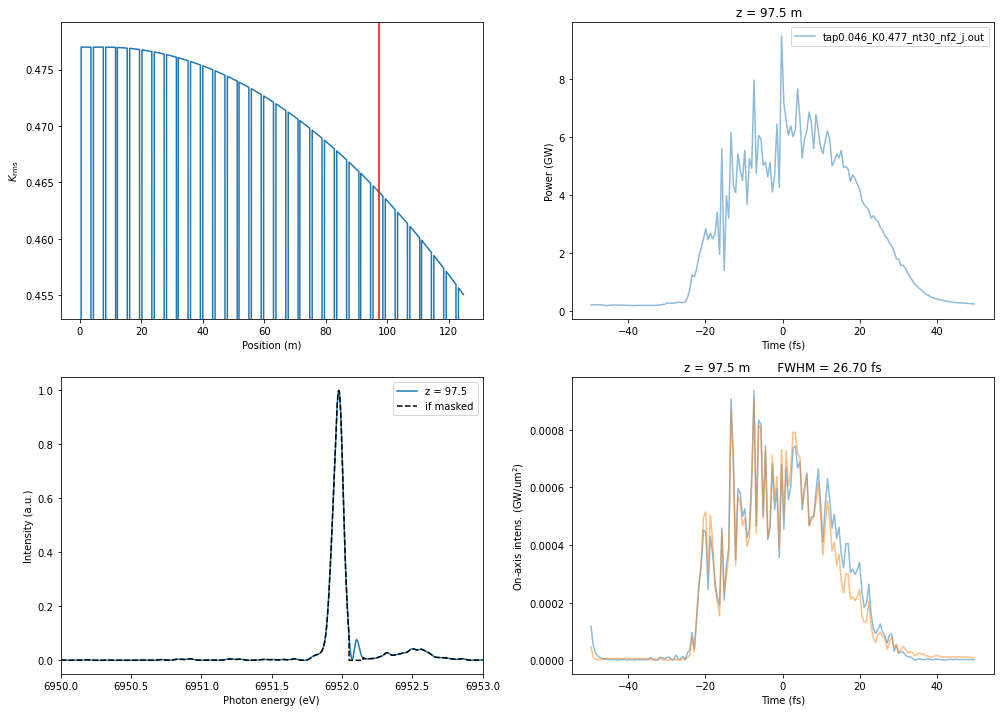

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  36.2625968  fs


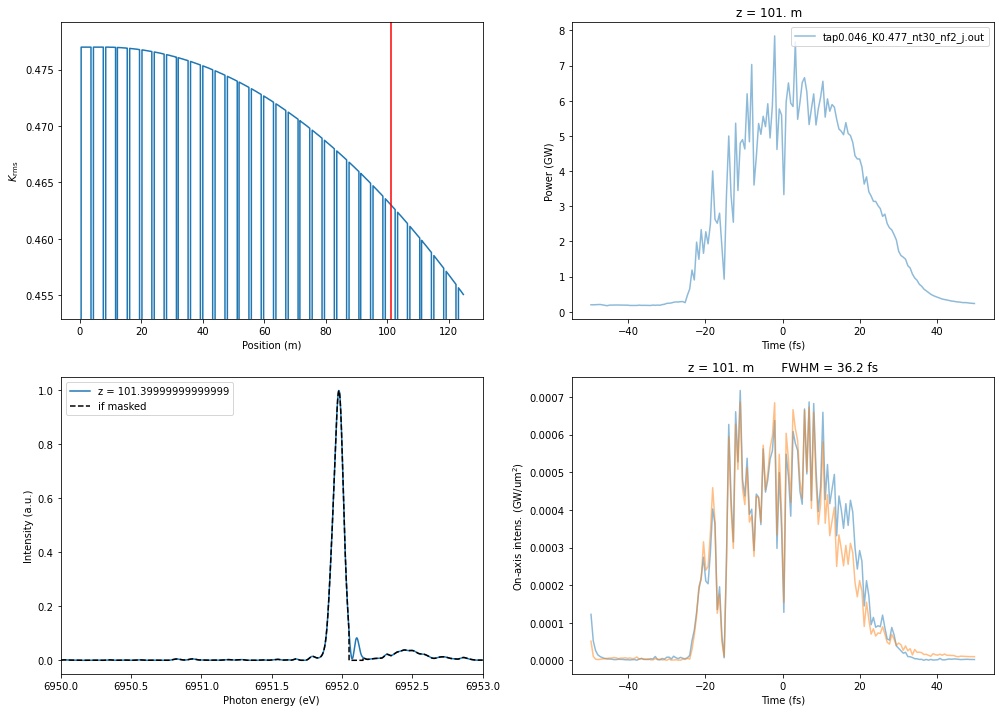

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  23.778751999999997  fs


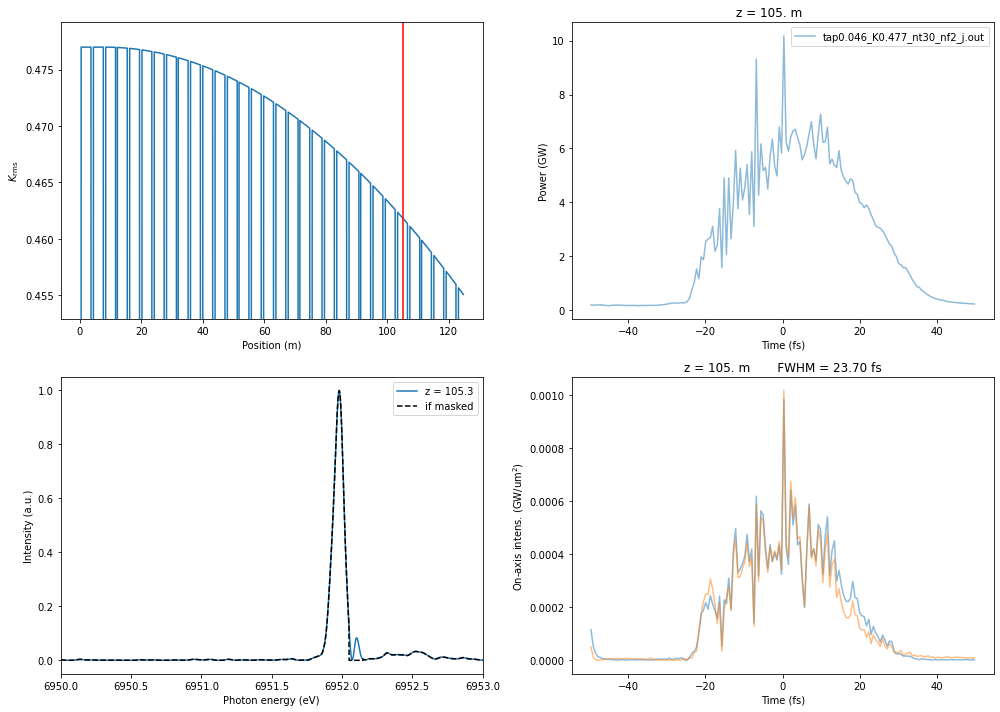

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  31.5068464  fs


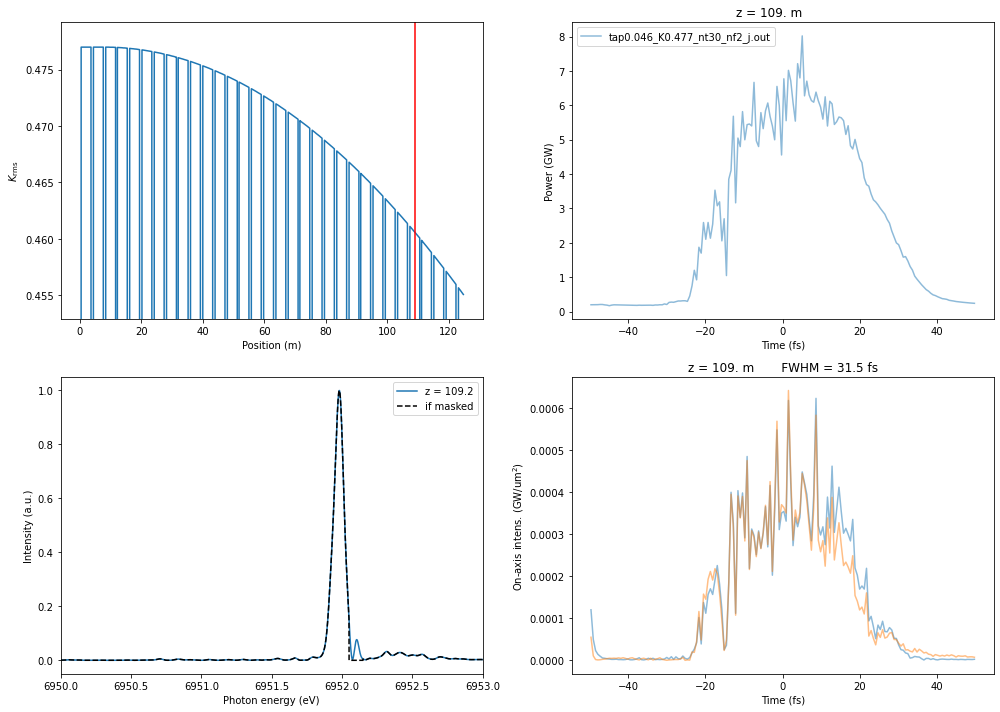

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  29.128971199999995  fs


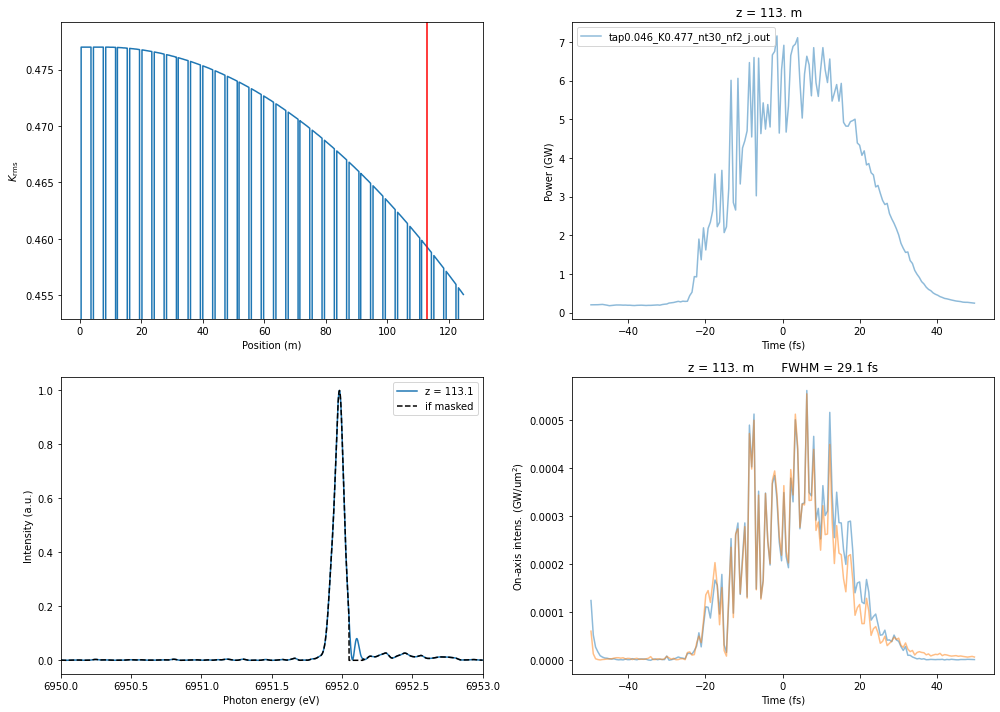

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  32.695784  fs


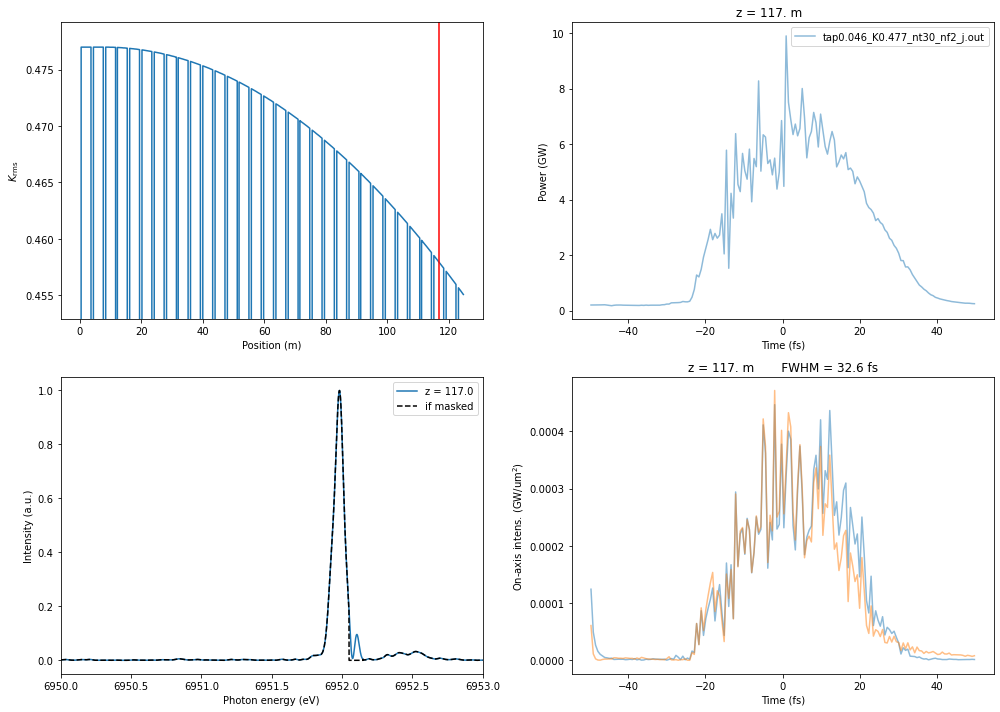

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  31.5068464  fs


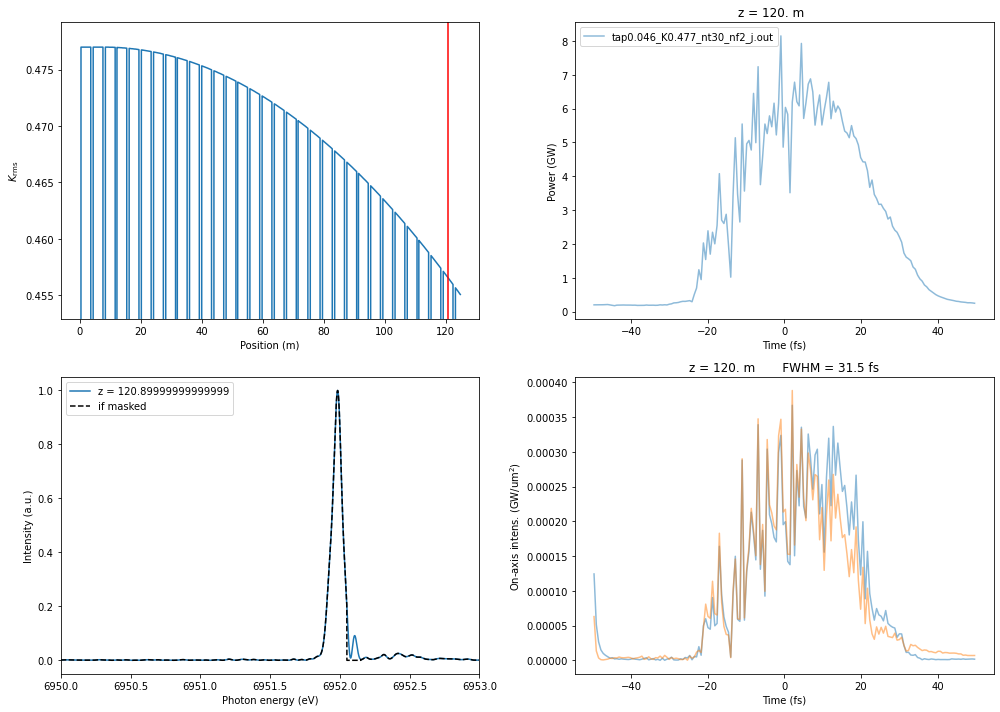

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  21.99534560000001  fs


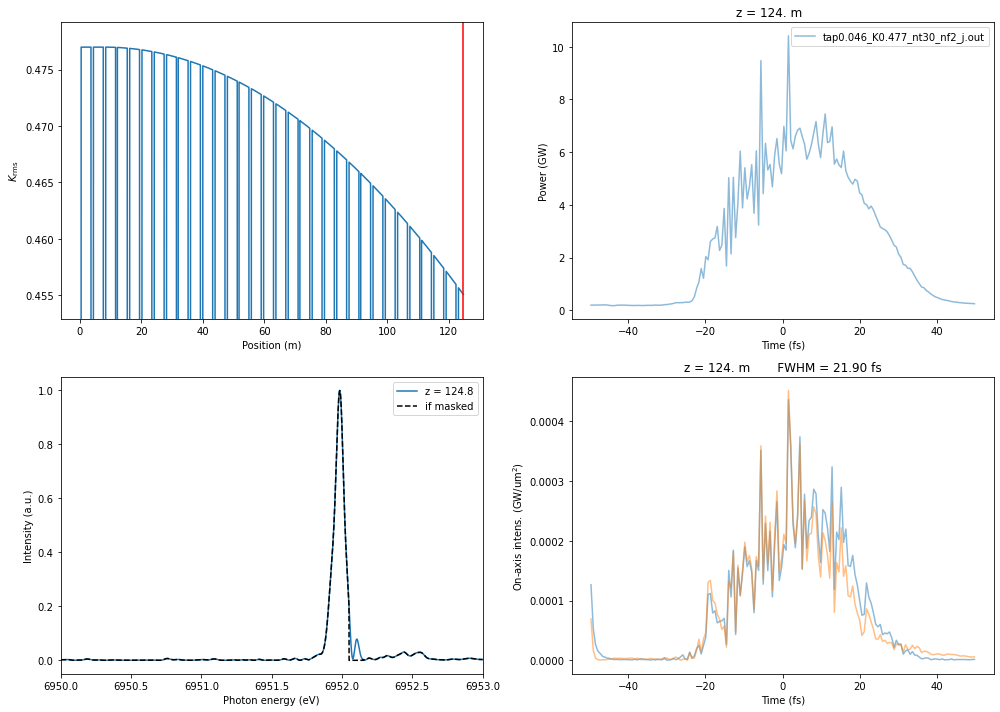

In [20]:
def plot_pow_pmid_spec(z,records,mask_width_eV=200e-3,xlim=None,ylim = None,figsize=(12+2,8+2),animationFrame=False):
    fig = plt.figure(num = 1, figsize=(6,4))
    fig.clf()

    # setup plots
    
    # unds
    ax = plt.subplot(2, 2, 1); plt.sca(ax)
    plotunds(records,legendQ=False,merge_plots=True)
    ylim = plt.ylim()
    plt.plot([z,z],ylim,color='r')
    
    # power
    ax = plt.subplot(2, 2, 2); plt.sca(ax)
    plot_powers(z,records,merge_plots=True)#,figsize=(6,4))
    
    # spectrum
    ax = plt.subplot(2, 2, 3); plt.sca(ax)
    plot_spectra(z,records,merge_plots=True,xlim = [6950,6953])
    
    # pmid
    ax = plt.subplot(2, 2, 4); plt.sca(ax)
    plot_pmid(z,records,merge_plots=True)
    
    plt.gcf().set_size_inches(figsize[0], figsize[1], forward=True)
    plt.tight_layout()
    
    if animationFrame:
        
        # Used to return the plot as an image rray
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        return image
        
    else:
        figpath = os.path.join(savefolder,'pow_pmid_spec_z'+str(np.int())+'.png')
        try:
            plt.savefig(figpath,bbox_inches='tight')
        except:
            print('WARNING: Could not save figure to', figpath)
    #         plt.savefig(savefolder+'/'+fnhead+'_output_power_many.png', bbox_inches='tight')
        if showPlotQ: plt.show(); 
        plt.close()

        plt.show()
    

Lund = 3.9
nund = np.int(max(zlist)/Lund)
for z in np.arange(nund+1)*Lund:
    plot_pow_pmid_spec(z,records,mask_width_eV=100e-3,xlim=None,ylim = None)

tap0.046_K0.477_nt30_nf2_j.out FWHM of power  99.27628960000001  fs
tap0.046_K0.477_nt30_nf2_j.out FWHM of power  24.373220799999995  fs
tap0.046_K0.477_nt30_nf2_j.out FWHM of power  31.506846399999993  fs
tap0.046_K0.477_nt30_nf2_j.out FWHM of power  19.023001600000008  fs
tap0.046_K0.477_nt30_nf2_j.out FWHM of power  23.778751999999997  fs
tap0.046_K0.477_nt30_nf2_j.out FWHM of power  28.534502399999994  fs
tap0.046_K0.477_nt30_nf2_j.out FWHM of power  23.778751999999997  fs
tap0.046_K0.477_nt30_nf2_j.out FWHM of power  38.640472  fs
tap0.046_K0.477_nt30_nf2_j.out FWHM of power  20.806407999999994  fs
tap0.046_K0.477_nt30_nf2_j.out FWHM of power  33.884721600000006  fs
tap0.046_K0.477_nt30_nf2_j.out FWHM of power  21.400876799999995  fs
tap0.046_K0.477_nt30_nf2_j.out FWHM of power  21.995345599999993  fs
tap0.046_K0.477_nt30_nf2_j.out FWHM of power  10.105969599999987  fs
tap0.046_K0.477_nt30_nf2_j.out FWHM of power  28.534502399999987  fs
tap0.046_K0.477_nt30_nf2_j.out FWHM of power

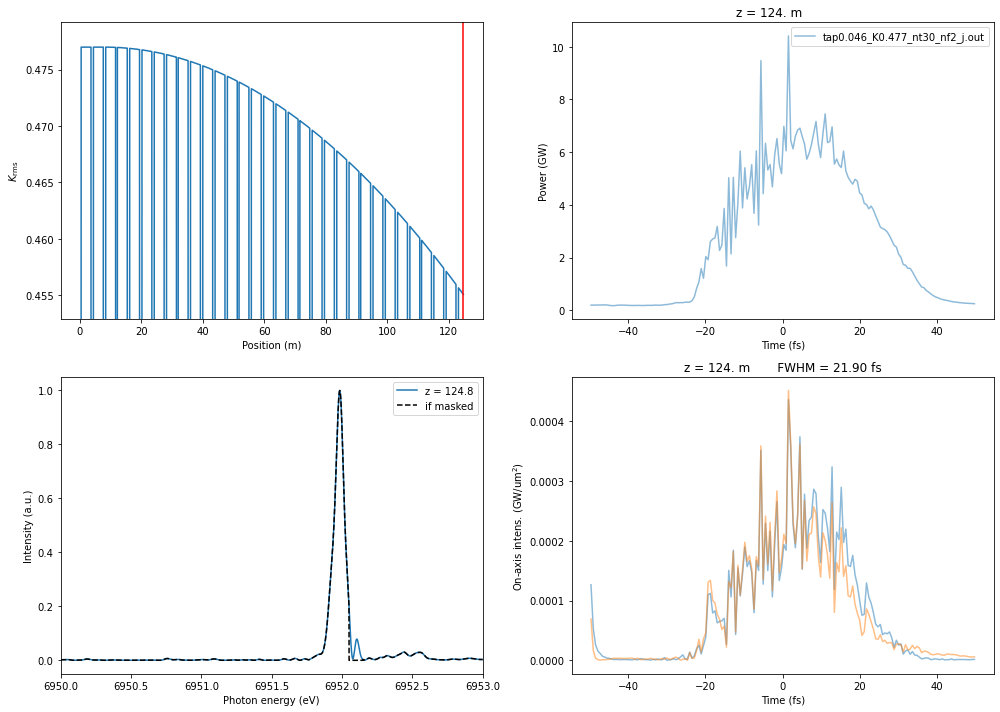

In [21]:
# https://ndres.me/post/matplotlib-animated-gifs-easily/
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import imageio

Lund = 3.9
nund = np.int(max(zlist)/Lund)
frames = [plot_pow_pmid_spec(z,records,mask_width_eV=200e-3,xlim=None,ylim=None,animationFrame=True) for z in np.arange(nund+1)*Lund]
for i in range(5):
    frames += [frames[-1]]

kwargs_write = {'fps':1.0, 'quantizer':'nq'}
figpath = os.path.join(savefolder,'pow_pmid_spec_vs_z.gif')
imageio.mimsave(figpath, frames, fps=0.5)

In [9]:
def plot_power_bandwith_vs_z(statfcn=[fwhm,mwhm,rms][0],color = 'C2'):
    pows_vs_z = []
    for z in zlist:
        pows_at_z = []
        for rec in records:
            sl,pl = get_powers(z,rec)
            pows_at_z += [np.max(pl)]
        pows_vs_z += [pows_at_z]
    pows_vs_z = np.transpose(pows_vs_z)*1e-9
    mp = np.mean(pows_vs_z, axis=0)
    count  = 0
    for p in pows_vs_z:
        count += 1
        plt.plot(zlist,p,color = 'C1', linestyle='dashed',label = files[count-1].split('/')[-1])
    
    plt.xlabel('Position (m)')
    plt.ylabel('Power(GW)',color = 'C1')
    
    ax = plt.gca()
    
    tax = ax.twinx()
    
    pows_vs_z = []
    for z in zlist:
        pows_at_z = []
        for rec in records:
            sl,pl = get_spectra(z,rec)
            slp = np.linspace(min(sl),max(sl),len(sl)*10)
            plp = interp1d(sl,pl)(slp)
            pows_at_z += [statfcn(plp)*(slp[1] - slp[0])]
        pows_vs_z += [pows_at_z]
    pows_vs_z = np.transpose(pows_vs_z)
    mp = np.mean(pows_vs_z, axis=0)
    for p in pows_vs_z:
        tax.plot(zlist,p,alpha=0.2)
    tax.plot(zlist,mp,color=color)
    
    tax.set_ylabel('FWHM Bandwith(eV)', color = 'g')
    #tax.set_ylim([0.08,0.2])

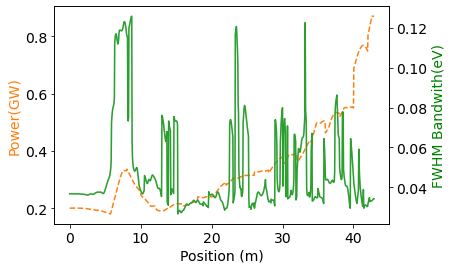

In [34]:
plot_power_bandwith_vs_z()

In [51]:
def sigma_to_fwhm(sigma):
    return 2. * np.sqrt(2 * np.log(2)) * sigma


def fwhm_to_sigma(fwhm):
    return fwhm / (2. * np.sqrt(2 * np.log(2)))


def intensity_fwhm_to_field_sigma(fwhm):
    return fwhm / (2. * np.sqrt(2 * np.log(2))) * np.sqrt(2)


def field_sigma_to_intensity_fwhm(sigma):
    return sigma * (2. * np.sqrt(2 * np.log(2))) / np.sqrt(2)


def bandwidth_sigma_kev_to_duration_sigma_fs(bandwidth_kev):
    return hbar / 2. / bandwidth_kev


def get_intensity_fwhm_duration_from_intensity_bandwidth(bandwidth_kev):
    # Convert intensity bandwidth to field bandwidth
    field_bandwidth = bandwidth_kev * np.sqrt(2)
    field_bandwidth_sigma = fwhm_to_sigma(field_bandwidth)

    # Calcualte the pulse duration
    field_duration_sigma = bandwidth_sigma_kev_to_duration_sigma_fs(field_bandwidth_sigma)
    field_duration_fwhm = sigma_to_fwhm(field_duration_sigma)

    # Convert the field duration fwhm to intensity duration fwhm
    intensity_duration_fwhm = field_duration_fwhm / np.sqrt(2)
    return intensity_duration_fwhm
"""
This module is the lowest-level module. It does not depend on another modules.
"""
pi = np.pi
two_pi = 2. * np.pi

hbar = 0.0006582119514  # This is the reduced planck constant in keV/fs

c = 299792458. * 1e-9  # The speed of light in um / fs

In [53]:
get_intensity_fwhm_duration_from_intensity_bandwidth(0.1e-3)

9.124755166475394

In [13]:
def get_spectra2(z, record, npad = 8000):
    iz = np.argmin(np.abs(record['zlist']-z))
    rz = record['zlist'][iz]
    zg = record['zgroups'].get_group(rz)
    dt = g.input['xlamds'] / 3e8 * g.input['zsep']
    temp = np.array(zg.slice)
    sep = temp[1] - temp[0]
    s = np.array(zg.slice) * dt
    pmid = np.array(zg.p_mid); phimid = np.array(zg.phi_mid)
    s_fs = s*1e15
    
    s2 = np.arange(s.shape[0] + 2*npad) * dt*sep
    s_fs2 = s2*1e15
    
    
    h_Plank = 4.135667696e-15
    c_speed  = 299792458
   
    ws = np.arange(s_fs2.shape[0]) / (s_fs2[-1] - s_fs2[0])
    ws -= np.mean(ws)
    hw0 = h_Plank * c_speed/g.input['xlamds']
    hws = h_Plank*1e15 * ws + hw0
  
    
    
    field = np.sqrt(pmid) * np.exp(1j * phimid) # units sqrt(GW/um^2)
    field = np.pad(field, (npad, npad))
    ftfld = np.fft.fftshift(np.fft.fft(field))
    spectra = np.abs(ftfld)**2
    return hws, spectra

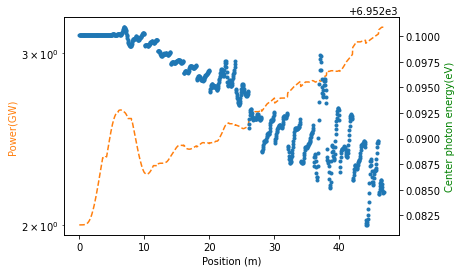

In [14]:
def plot_spectral_center_vs_z():
    pows_vs_z = []
    for z in zlist:
        pows_at_z = []
        for rec in records:
            sl,pl = get_powers(z,rec)
            pows_at_z += [np.max(pl)]
        pows_vs_z += [pows_at_z]
    pows_vs_z = np.transpose(pows_vs_z)*1e-9
    mp = np.mean(pows_vs_z, axis=0)
    count  = 0
    for p in pows_vs_z:
        count += 1
        plt.plot(zlist,p,color = 'C1', linestyle='dashed',label = files[count-1].split('/')[-1])
        plt.yscale('log')
    plt.xlabel('Position (m)')
    plt.ylabel('Power(GW)',color = 'C1')
    
    ax = plt.gca()
    
    tax = ax.twinx()

    pcenter_vs_z = []
    pcenter_at_z = []
    pcenter_at_z2 = []
    for z in zlist:
       
        for rec in records:
            sl,pl = get_spectra2(z,rec, npad = 60000)
            slp = np.linspace(min(sl),max(sl),len(sl)*1)
            plp = interp1d(sl,pl)(slp)
            pcenter_at_z += [slp[np.argmax(plp)]]
            pcenter_at_z2+= [np.sum(slp*plp)/np.sum(plp)]
        #center_vs_z += [pcenter_at_z]
    #pcenter_vs_z = np.transpose(pcenter_vs_z)

    #mp = np.mean(pcenter_vs_z, axis=0)
   
    tax.plot(np.array(zlist),pcenter_at_z2, '.')
    #tax.plot(np.array(zlist), pcenter_at_z2, '.')

    tax.set_ylabel('Center photon energy(eV)', color = 'g')
    #tax.set_ylim([0.08,0.2])
    
    return zlist, pcenter_at_z, p


    
zlist, pcenter_at_z, power = plot_spectral_center_vs_z()

#pickle.dump( (zlist, pcenter_at_z, power), open( "chirp30.p", "wb" ) )

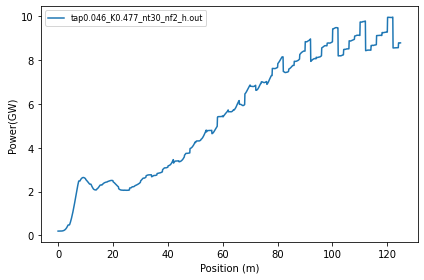

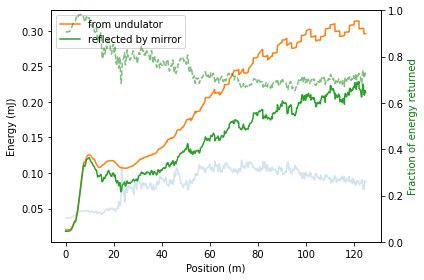

No handles with labels found to put in legend.


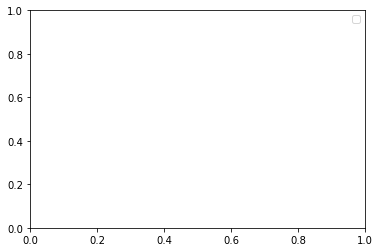

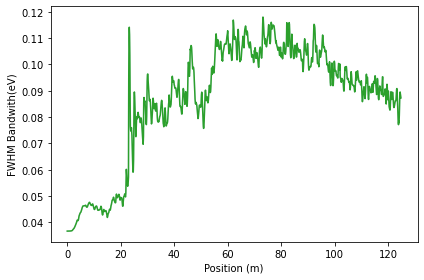

In [19]:
def plot_peak_powers_vs_z(color='C2',xlim=None,ylim=None,statfcn=[fwhm,mwhm,rms][0],merge_plots=False):
    pows_vs_z = []
    for z in zlist:
        pows_at_z = []
        for rec in records:
            sl,pl = get_powers(z,rec)
            pows_at_z += [np.max(pl)]
        pows_vs_z += [pows_at_z]
    pows_vs_z = np.transpose(pows_vs_z)*1e-9
    mp = np.mean(pows_vs_z, axis=0)
    count  = 0
    for p in pows_vs_z:
        count += 1
        plt.plot(zlist,p,label = files[count-1].split('/')[-1])
    #plt.plot(zlist,mp,color=color,label='Power (GW)')
    if xlim != None: plt.xlim(xlim)
    if ylim != None: plt.ylim(ylim)
    plt.xlabel('Position (m)')
    plt.ylabel('Power(GW)')
    plt.legend(fontsize = 8)
    plt.tight_layout()
    if not merge_plots:
        plt.savefig(savefolder+'/'+fnhead+'_powervsz_many.png', bbox_inches='tight')
        if showPlotQ: plt.show(); 
        plt.close()
    pows_vs_z = []
    for z in zlist:
        pows_at_z = []
        for rec in records:
            sl,pl = get_spectra(z,rec)
            slp = np.linspace(min(sl),max(sl),len(sl)*10)
            plp = interp1d(sl,pl)(slp)
            pows_at_z += [statfcn(plp)*(slp[1] - slp[0])]
        pows_vs_z += [pows_at_z]
    pows_vs_z = np.transpose(pows_vs_z)
    mp = np.mean(pows_vs_z, axis=0)
    for p in pows_vs_z:
        plt.plot(zlist,p,alpha=0.2)

def plot_pulse_energies_vs_z(color='C0',xlim=None,ylim=None,merge_plots=False):
    pows_vs_z = []
    frac_pow_vs_z = []
    rpows_vs_z = []
    for z in zlist:
        pows_at_z = []
        rpows_at_z = []
        frac_pow_at_z = []
        for rec in records:
            sl,pl = get_powers(z,rec)
            pows_at_z += [np.sum(pl)*(sl[1]-sl[0])]
            hws, spectra, mask, netrm, pctrm =get_spectra(z, rec, mask_width_eV=100e-3)
            rpows_at_z += [np.sum(pl)*(sl[1]-sl[0])*pctrm/100]
            frac_pow_at_z += [pctrm/100]
        pows_vs_z += [pows_at_z]
        rpows_vs_z += [rpows_at_z]
        frac_pow_vs_z += [frac_pow_at_z]
    pows_vs_z = np.transpose(pows_vs_z)*1e3
    rpows_vs_z = np.transpose(rpows_vs_z)*1e3
    frac_pow_vs_z = np.transpose(frac_pow_vs_z)
    mp = np.mean(pows_vs_z, axis=0)
    count = 0
    for p in pows_vs_z:
        count += 1
        plt.plot(zlist,p, label = 'from undulator')
    count = 0
    for pr in rpows_vs_z:
        count += 1
        plt.plot(zlist,pr, label = 'reflected by mirror')
    ax = plt.gca()
    ax.set_xlabel('Position (m)')
    ax.set_ylabel('Energy (mJ)')
    plt.legend()
    tax = ax.twinx()
    for fpr in frac_pow_vs_z:
        tax.plot(zlist, fpr,'g--', alpha = 0.5)
    tax.set_ylabel('Fraction of energy returned', color = 'g')
    tax.set_ylim([0,1])
    #plt.plot(zlist,mp,color=color,label='Energy (mJ)')
    if xlim != None: plt.xlim(xlim)
    if ylim != None: plt.ylim(ylim)
    
    plt.tight_layout()
    
    if not merge_plots:
        plt.savefig(savefolder+'/'+fnhead+'_pulseenergyvsz_many.png', bbox_inches='tight')
        if showPlotQ: plt.show(); 
        plt.close()

def plot_relative_bandwidth_vs_z(color='C1',xlim=None,ylim=None,statfcn=[fwhm,mwhm,rms][1],merge_plots=False):
    pows_vs_z = []
    for z in zlist:
        pows_at_z = []
        for rec in records:
            sl,pl = get_spectra(z,rec)
            slp = np.linspace(min(sl),max(sl),len(sl)*10)
            plp = interp1d(sl,pl)(slp)
            pows_at_z += [statfcn(plp)*(slp[1] - slp[0])]
        pows_vs_z += [pows_at_z]
    pows_vs_z = np.transpose(pows_vs_z)
    mp = np.mean(pows_vs_z, axis=0)
    for p in pows_vs_z:
        plt.plot(zlist,p,alpha=0.2)
    plt.plot(zlist,mp,color=color)
    if xlim != None: plt.xlim(xlim)
    if ylim != None: plt.ylim(ylim)
    plt.xlabel('Position (m)')
    plt.ylabel('FWHM Bandwith(eV)')
    plt.tight_layout()
    if not merge_plots:
        plt.savefig(savefolder+'/'+fnhead+'_bwvsz_many.png', bbox_inches='tight')
        if showPlotQ: plt.show(); 
        plt.close()

plot_peak_powers_vs_z(merge_plots=False)
plot_pulse_energies_vs_z(merge_plots=False)
#plot_relative_bandwidth_vs_z(merge_plots=True,statfcn=fwhm,color='C1') #comment out
#plot_relative_bandwidth_vs_z(merge_plots=True,statfcn=mwhm,color='C2') # any of these
#plot_relative_bandwidth_vs_z(merge_plots=True,statfcn=rms,color='C3') # to customize
#plt.ylim([0,1.]); 
plt.legend(fontsize = 10)
plt.savefig(savefolder+'/'+fnhead+'_bwandenergyvs_many.png', bbox_inches='tight')
if showPlotQ: plt.show(); 
plt.close()

#plot_peak_powers_vs_z(merge_plots=True)
#plot_pulse_energies_vs_z(merge_plots=True)
# plot_relative_bandwidth_vs_z(merge_plots=True,statfcn=fwhm,color='C1') #comment out
plot_relative_bandwidth_vs_z(merge_plots=True,statfcn=mwhm,color='C2') # any of these
#plot_relative_bandwidth_vs_z(merge_plots=True,statfcn=rms,color='C3') # to customize
#plt.ylim([0,1.]); plt.legend()
#plt.savefig(savefolder+'/'+fnhead+'_bwandenergyvs_many.png', bbox_inches='tight')
#if showPlotQ: plt.show(); 
#plt.close()

In [ ]:

#     if useMask:
#         ax1.plot(hws, spectra, label='unmasked', **marker_style)
#         ax1.plot(hws, mask * spectra, label='masked', **marker_style)
#         ax1.legend()
#     else:
#         ax1.plot(hws, spectra, **marker_style)
        
#     ax1.set_xlabel('Photon energy (eV)', fontsize = fontsize)
#     #ax1.set_ylabel(r'Spectral intensity (uJ/eV)', fontsize = fontsize)#, color = cm.cividis(ii / iimax))
#     ax1.set_ylabel('On-axis spectral fluence\n(uJ/um$^2$/eV)', fontsize = fontsize)#, color = cm.cividis(ii / iimax))
#     # display figure
#     plt.tight_layout()
#     plt.savefig(savefolder+'/'+fnhead+'_output_spectra.png', bbox_inches='tight')
#     if showPlotQ: plt.show(); 
#     plt.close()

Text(0, 0.5, 'Energy (MeV)')

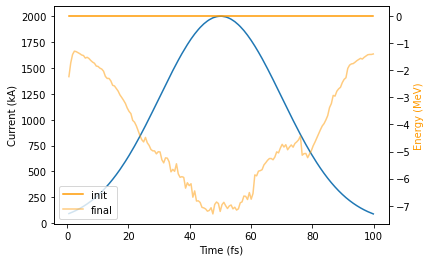

In [20]:
fig, ax = plt.subplots()
slist_fs, currlist = getmeanovers('currlist')
ax.plot(slist_fs, currlist)
ax.set_xlabel('Time (fs)')
ax.set_ylabel('Current (kA)')
axr = ax.twinx()
slist_fs, energylist_init = getmeanovers('energylist_init')
axr.plot(slist_fs, energylist_init, '#ff9900', label='init')
slist_fs, energylist_fin = getmeanovers('energylist_fin')
axr.plot(slist_fs, energylist_fin, '#ff9900', alpha=0.5, label='final')
axr.legend()
axr.set_ylabel('Energy (MeV)', color = '#ff9900')

In [22]:
235*40*1.261043e-10/3e8

3.951268066666667e-15

ValueError: num must be 1 <= num <= 16, not 17

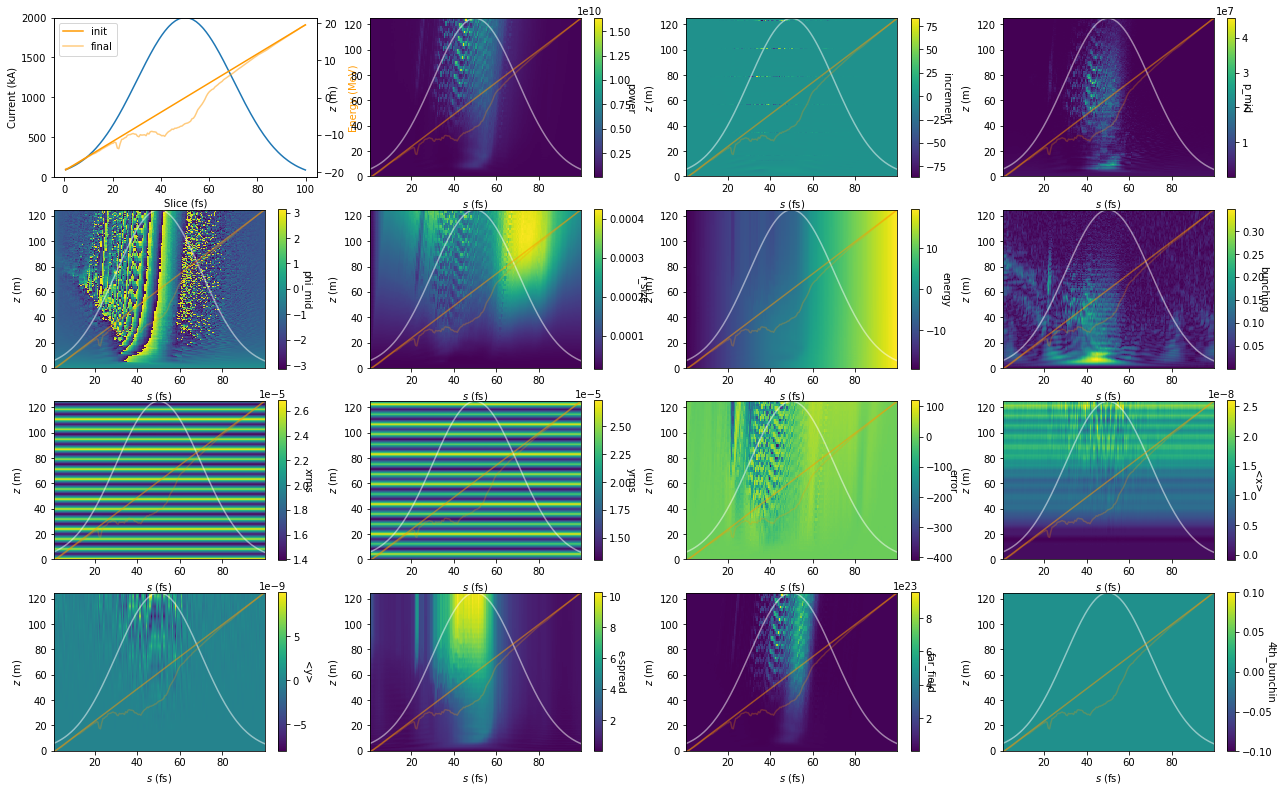

In [27]:

#########################################
# plot properties for z vs slice for various zs

# setup figure
#fig = plt.figure(num = 1, figsize = 3.375 * np.array([1.61 * 3, 1]))
fig = plt.figure(num = 1, figsize = 3.375 * np.array([1.61 * 4, 4]))
fig.clf()
marker_style = dict(marker = '',
        linewidth = 2, markerfacecoloralt = 'gray', markeredgecolor = 'none')
e_style = dict(marker = '.', linestyle = '',
        markersize = 2, markerfacecoloralt = 'gray', markeredgecolor = 'none')

# setup plots
ax = plt.subplot(4, 4, 1)
slist_fs, currlist = getmeanovers('currlist')
ax.plot(slist_fs, currlist)
ax.set_xlabel('Slice (fs)')
ax.set_ylabel('Current (kA)')
ax.set_ylim(0, np.max(currlist))
axr = ax.twinx()
slist_fs, energylist_init = getmeanovers('energylist_init')
axr.plot(slist_fs, energylist_init, '#ff9900', label='init')
slist_fs, energylist_fin = getmeanovers('energylist_fin')
axr.plot(slist_fs, energylist_fin, '#ff9900', alpha=0.5, label='final')
axr.legend()
axr.set_ylabel('Energy (MeV)', color = '#ff9900')
currlist_scaled = currlist - 0*np.min(currlist); currlist_scaled /= np.max(currlist_scaled); currlist_scaled *= np.max(zlist) - np.min(zlist); currlist_scaled += np.min(zlist)
energylist_init_scaled = energylist_init - np.min(energylist_fin); energylist_init_scaled /= np.max(energylist_init_scaled); energylist_init_scaled *= np.max(zlist) - np.min(zlist); energylist_init_scaled += np.min(zlist)
energylist_fin_scaled = energylist_fin - np.min(energylist_fin); energylist_fin_scaled /= np.max(energylist_fin_scaled); energylist_fin_scaled *= np.max(zlist) - np.min(zlist); energylist_fin_scaled += np.min(zlist)
# NOTE: havent averaged over ipseeds in this loop yet
for ia in np.arange(3,outputdat.shape[1]):
    ax = plt.subplot(4, 4, ia - 2 + 1)
    #ax_r = ax.twinx()
    pdat = np.reshape(np.array(outputdat.iloc[:,ia]), [int(outputdat.shape[0] / len(zlist)), len(zlist)]).T
    im = ax.imshow(pdat, interpolation = 'none', extent = [slist_fs[0], slist_fs[-1], zlist[0], zlist[-1]], origin = 'lower', aspect = 0.75*(slist_fs[-1] - slist_fs[0]) / (zlist[-1] - zlist[0]))
    ax.set_xlabel('$s$ (fs)')
    ax.set_ylabel('$z$ (m)')
    #ax_r.set_ylabel('Dashed line: current (kA)')
    #ax.set_title(outputdat.keys()[ia])
    cbar = fig.colorbar(im, ax = ax)
    cbar.set_label(outputdat.keys()[ia], rotation = 270)
    ax.plot(slist_fs, currlist_scaled, 'w', alpha = 0.5, scalex = False, scaley = False);
    ax.plot(slist_fs, energylist_init_scaled, '#ff9900', alpha = 0.5, scalex = False, scaley = False);
    ax.plot(slist_fs, energylist_fin_scaled, '#ff9900', alpha = 0.25, scalex = False, scaley = False);
    #ax_r.set_yticks([]) # remove right y-axis
    # ninja stuff for plotting colorbars for each subplot: https://matplotlib.org/examples/pylab_examples/custom_cmap.html

# display figure
plt.tight_layout()
plt.savefig(savefolder+'/'+fnhead+'_2dplots.png', bbox_inches='tight')
if showPlotQ: plt.show(); 
plt.close()

In [37]:
g = 14.584615


3.9

In [ ]:

############################################
# plot last slice power

# setup figure
fontsize = 16
marker_style = dict(marker = '',
        linewidth = 2, markerfacecoloralt = 'gray', markeredgecolor = 'none')
e_style = dict(marker = '.', linestyle = '',
        markersize = 2, markerfacecoloralt = 'gray', markeredgecolor = 'none')
        
#fig = plt.figure(num = 1, figsize = [3.375 * 1.61 * 1, 3.375])
#fig.clf()
#ax1 = plt.subplot(1, 1, 1)
##ii = 0; iimax = len(zgroups) - 1.
##skip = np.int(iimax); # grab zstep with max power
##for name,group in zgroups:
    ##ii = ii + 1;
    ##if np.mod(ii, skip) != 0: continue
    
#ax1.plot(slist_fs, group["power"].values * 1e-9, **marker_style)
#ds = slist_fs[1] - slist_fs[0]
#pdf = group["power"].values / (np.sum(group["power"].values) )
#print('check norm: ', np.sum(pdf));
#smean = np.sum(pdf * slist_fs)
#s2mean = np.sum(pdf * slist_fs**2)
#srms = np.sqrt(s2mean - smean**2)
#print('smean = ', smean)
#print('s2mean = ', s2mean)
#print('srms = ', srms)
#cdf = np.cumsum(pdf)
#smed = np.interp(0.5, cdf, slist_fs); s50=smed
##s05 = np.interp(0.05, cdf, slist_fs)
#s10 = np.interp(0.1, cdf, slist_fs)
#s90 = np.interp(0.9, cdf, slist_fs)
##s95 = np.interp(0.95, cdf, slist_fs)
#print('80% of power within ', s90-s10, ' fs of median ', smed ,'fs')
#print('peak average power ', max(pows) *1.e-9, ' GW')
#print('average pulse energy ', np.sum(pows) * ds * 1e-15 * 1e-6, ' uJ')
#ax1.set_xlabel(r'$s$ (fs)', fontsize = fontsize)
#ax1.set_ylabel(r'Power (GW)', fontsize = fontsize)#, color = cm.cividis(ii / iimax))
## display figure
#plt.tight_layout()
#plt.savefig(savefolder+'/'+fnhead+'_output_power.png', bbox_inches='tight')
#if showPlotQ: plt.show(); 
#plt.close()


fig = plt.figure(num = 1, figsize = [3.375 * 1.61 * 1, 3.375])
fig.clf()
ax1 = plt.subplot(1, 1, 1)
#ii = 0; iimax = len(zgroups) - 1.
#skip = np.int(iimax); # grab zstep with max power
#for name,group in zgroups:
    #ii = ii + 1;
    #if np.mod(ii, skip) != 0: continue
    ##field = np.sqrt(group["p_mid"].values) * np.exp(1j * group["phi_mid"].values)
    ##fieldac = np.abs(np.fft.ifft(np.abs(np.fft.fft(field))**2))
    
pows = getmeanpowers()
ax1.plot(slist_fs, pows * 1e-9, **marker_style)
ds = slist_fs[1] - slist_fs[0]
pdf = pows / (np.sum(pows) )
print('check norm: ', np.sum(pdf));
smean = np.sum(pdf * slist_fs)
s2mean = np.sum(pdf * slist_fs**2)
srms = np.sqrt(s2mean - smean**2)
print('smean = ', smean)
print('s2mean = ', s2mean)
print('srms = ', srms)
cdf = np.cumsum(pdf)
smed = np.interp(0.5, cdf, slist_fs); s50=smed
#s05 = np.interp(0.05, cdf, slist_fs)
s10 = np.interp(0.1, cdf, slist_fs)
s90 = np.interp(0.9, cdf, slist_fs)
#s95 = np.interp(0.95, cdf, slist_fs)
print('peak average power', max(pows) *1.e-9, ' GW')
print('average pulse energy', np.sum(pows) * ds * 1e-15 * 1e6, ' uJ')
print('ds = ',ds)
sfwhm = fwhm(pows)
print('sfwhm = ', sfwhm)
sfwhm = sfwhm * ds
print('fwhm of power', sfwhm, 'fs')
smwhm = mwhm(pows)
print('smwhm = ', smwhm)
smwhm = smwhm * ds
print('mwhm of power', smwhm, 'fs')
from scipy.signal import medfilt
pows0 = np.array(pows)
for ks in [7.,8.,9.]:
    print('kernel size of ',ks,'fs')
    pows = medfilt(pows0, kernel_size=int(ks/ds/2.)*2+1)
    ax1.plot(slist_fs, pows * 1e-9)
    sfwhm = fwhm(pows)
    print('sfwhm = ', sfwhm)
    sfwhm = sfwhm * ds
    print('fwhm of power', sfwhm, 'fs (median filtered)')
    smwhm = mwhm(pows)
    print('smwhm = ', smwhm)
    smwhm = smwhm * ds
    print('mwhm of power', smwhm, 'fs (median filtered)')

ax1.set_xlabel(r'$s$ (fs)', fontsize = fontsize)
ax1.set_ylabel(r'Power (GW)', fontsize = fontsize)#, color = cm.cividis(ii / iimax))
# display figure
plt.tight_layout()
plt.savefig(savefolder+'/'+fnhead+'_output_power.png', bbox_inches='tight')
if showPlotQ: plt.show(); 
plt.close()


In [13]:
(1.5675146771E+04 - 1.5636007828E+04)*0.511

19.99999987299996